# Milestone 5 Final Project Notebook

## Group: Benito Isaac, Faisal Karim, and Caleb Saul

# Table of Contents

- Librarires and Envionment Configurations
- Problem Statement
- Exploratory Data Analysis and Visualizetion
- Data Splitting
- Organizing Local Directory Structure
- Basline Logistic Regression Model 
     - Model Fitting
     - Model Results
- Introducing the Data Image Generator
- Basic CNN Model
    - Model Fitting
    - Model Flowchart
    - Model Results
- Introducing Upsampling For Class Balancing
- Introducing Data Augmentation
- CNN Model With Data Augmentation and Balanced Classes
    - Model Fitting
    - Model Flowchart
    - Model Results
- Introducing Transfer Learning
- Transfer Learning CNN Model with RESNET Base, Data Augmentation, and Balanced Classes
    - Model Fitting
    - Model Flowchart
    - Model Results
- Transfer Learning CNN Model with MobileNet Base, Data Augmentation, and Balanced Classes
    - Model Fitting
    - Model Flowchart
    - Model Results
- 209 Extension: Convolutional XGBoost with Data Augmentation and Balanced Classes
    - Model Fitting
    - Model Results
- Conclusion
    - Final Model Result Comparisons
    - Strengths and Weaknesses
    - Limitations and Future Works


# Libraries and Environmental Configurations

The following libraries and imports are required to run this notebook.  There are no special environment configurations for this code to run; the baseline CS109b environment created at the beginning of class is all that is used.  Users may need to pip install mat73 if they have never used it before, however. It is a small library for loading in matlab files into Python which is used because the raw data comes in the form of matlab files. Users will also need ot install pydot and graphviz (if they are not already installed), in order to use the plot_model function to save a visualization of their results.

In [143]:
#adding several imports that will be of use later
#pip install pydot
#pip install graphviz
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
#!pip install mat73
#from mat73 import loadmat
from tqdm import tqdm
from PIL import Image
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
import imageio
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import  Activation, Input, BatchNormalization, Dense, Dropout, Flatten, GaussianNoise
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import regularizers
from tensorflow import keras
from tensorflow.keras import layers
#!pip install xgboost
import xgboost as xgb
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPool2D, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LambdaCallback
from pathlib import Path

# Introducing The Problem - Brain Tumor Classification

Accurate classification of brain tumors is essential for the best diagnosis and treatment of patients. While simple on paper, in reality, the classification of brain tumors has proven to be a difficult task. Tumors of the same type can differ widely in their shape, margin, size, texture, severity, age, and other factors; additionally, tumors of different types can exhibit similar appearances. Some examples of this are shown below:

<div>
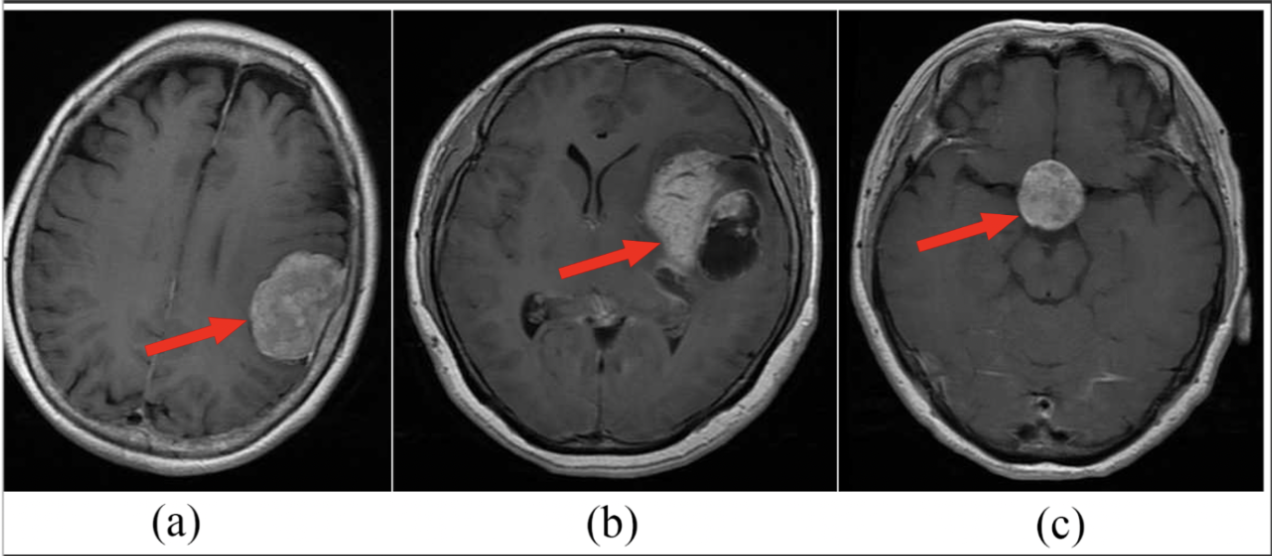
</div>

“Both (a) and (b) are meningiomas, but they have very different appearances. Although (c) is a pituitary tumor, it exhibits similar appearances to (a). Red arrows indicate tumors” (if the images do not load, the same examples can be found in figure 1 of this paper https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0157112)


### Our Task

Can we develop a machine learning model that can accurately classify three different types of brain tumors – Meningioma, Glioma, and Pituitary – using MRI image data?

To accomplish this, we will employ a range of approaches, beginning with a baseline logistic regression model before transitioning to various Convolutional Neural Network (CNN) architectures. Throughout the CNN-based exploration, we will investigate the potential benefits of transfer learning by utilizing pre-trained models specifically designed for biomedical image classification tasks, such as U-net, V-net, and ResNet etc. To evaluate the performance of our models, we will use metrics such as accuracy, precision, recall, and f-score. We will also compare results from saliency mapping to true tumor mask data to determine if our models are successfully identifying tumor regions of the image to do classification.

# Explore and Visualize Data:

The data we will be using for this task comes from the FIGSHARE database: https://figshare.com/articles/dataset/brain_tumor_dataset/1512427.; it has already been substantially cleaned up and is well-labeled. The dataset contains 3064 T1-weighted contrast-enhanced images (grey-scale) of three kinds of brain tumors – meningioma, glioma, and pituitary – from 233 patients.  Representative images that have large lesion sizes were selected to construct the dataset. The raw data is in the form of Matlab data format (.mat file), where each file stores a struct containing the following fields for an image: cjdata.label: 1 for meningioma, 2 for glioma, 3 for pituitary tumor; cjdata.PID: patient ID; cjdata.image: image data; cjdata.tumorBorder: a vector storing the coordinates of discrete points on the tumor border; and cjdata.tumorMask: a binary image with 1s indicating tumor region. For the scope of our project, we are concerned with the image data, the patient IDs, the tumor mask, and the corresponding label.  The image data and corresponding labels will be used to train our classifier, a supervised learning task.  The patient IDs are used to prevent data leakage, ensuring that we do not have patient overlap between our train/validation/test split (a stricter constraint than just not having overlapping images).  The tumor mask will be used later in interpretation, where we examine, through saliency mappings, if our network correctly learned to focus on the parts of the images with tumors.

The following code can be used to read in the raw data files into a numpy array.  It assumes one has already downloaded the data from FIGSHARE and saved it in a directory "data" with the name data/brainTumorDataPublic_1-766 (or 767-1532 or 1533-2298 or 2299-3064, for the corresponding images).  Note because a few of the images are 512 by 512, when we read them in, we will resize them to 512 to 512, matching the dimensions of the other images.  This will allow us to store the images in an array, making EDA easier.

In [2]:
#keeping track of how many images we needed to resize
count_512 = 0
count_256 = 0

data_folders = ['1-766', '767-1532', '1533-2298', '2299-3064']
image_numbers = [[x for x in range(1,767)],
              [x for x in range(767,1533)],
              [x for x in range(1533,2299)],
              [x for x in range(2299,3065)]]

#setting up arrays to store images, labels, and patient IDs for EDA
#tumor_images = np.zeros((512,512,3064)).astype(np.int16)
tumor_labels = np.zeros(3064).astype(np.int8)
patient_ids = np.zeros(3064, dtype = "S10")

for f, im_nums in zip(data_folders,image_numbers):
    for im_num in tqdm(im_nums):
        mat = loadmat(f'data/brainTumorDataPublic_{f}/{im_num}.mat')
        
        if mat['cjdata']['image'].shape == (256, 256):
            
            image_resized = np.array(Image.fromarray(mat['cjdata']['image']).resize((512,512))).astype(np.int16)
            #tumor_images[:,:, im_num-1] = image_resized
            count_256 += 1
        
        else:
            #tumor_images[:,:, im_num-1] = mat['cjdata']['image'].astype(np.int16)
            count_512 += 1
            
        tumor_labels[im_num-1] = int(mat['cjdata']['label'])
        
        patient_ids[im_num-1] = str(mat['cjdata']['PID'])

100%|████████████████████████████████████████| 766/766 [00:03<00:00, 233.42it/s]


Now that we have the images, labels, and patient IDs, we can do some EDA to get a deeper understanding of our data.  


The first thing we can check is if there are any missing values in the dataset:

In [27]:
if np.isnan(tumor_images).sum() == 0:
    print('no missing values in images')
    
if np.isnan(tumor_labels).sum() == 0:
    print('no missing values in labels')
    
if sum([1 if id_ is None else 0 for id_ in patient_ids]) == 0:
    print('no missing values in patient ids')

no missing values in images
no missing values in labels
no missing values in patient ids


We find there are no missing values.

The second thing we can check is how many images of each size we had in the dataset:

In [3]:
print(f'Our dataset has {count_512} 512 by 512 images and {count_256} 256 by 256 images\n')


Our dataset has 3049 512 by 512 images and 15 256 by 256 images



Clearly the majority are 512 by 512, so its good that we resized the few 256 by 256 ones to match the 512 by 512 ones, because if we had resized the 512 by 512 ones we would be losing significant amounts of information.

Next we can check the distribution of pixel values in our images.

The mean pixel value in the raw images is 467.3856354967421
The min pixel value in the raw images is -14
The max pixel value in the raw images is 12728


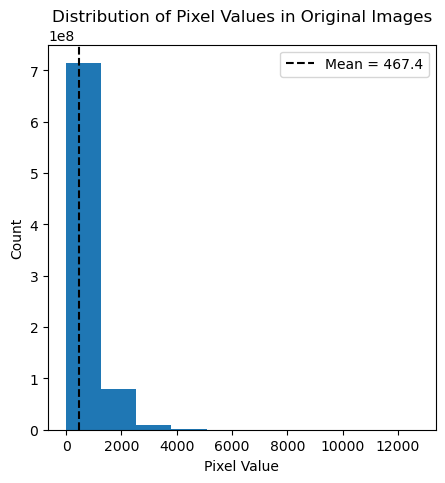

In [4]:
print(f'The mean pixel value in the raw images is {tumor_images.mean()}')
print(f'The min pixel value in the raw images is {tumor_images.min()}')
print(f'The max pixel value in the raw images is {tumor_images.max()}')
plt.figure(figsize = (5,5))
plt.hist(tumor_images.flatten())
plt.axvline(tumor_images.mean(), color = 'k', linestyle = '--',label = f'Mean = {tumor_images.mean():.1f}')    
plt.title('Distribution of Pixel Values in Original Images')
plt.xlabel('Pixel Value')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.show()

From this we can see that while most pixels have values 0-1000, the highest has a value over 12728.  It would be more convenient to have all our images be on the same scale, and for this scale to range from 0-255.  This would allow us to store our images in an array with 8-bit integers, which takes up less memory on our machines as well.  The code below will load in the images again, but this time rescaling each one to have pixels going from 0-255 and storing them in an array with dtype 8-bit integer.

In [3]:
data_folders = ['1-766', '767-1532', '1533-2298', '2299-3064']
image_numbers = [[x for x in range(1,767)],
              [x for x in range(767,1533)],
              [x for x in range(1533,2299)],
              [x for x in range(2299,3065)]]

#setting up arrays to store images
tumor_images = np.zeros((512,512,3064), dtype = np.uint8)

for f, im_nums in zip(data_folders,image_numbers):
    for im_num in tqdm(im_nums):
        mat = loadmat(f'data/brainTumorDataPublic_{f}/{im_num}.mat')
        
        #normalizing pixel values between 0 and 255
        norm_image = cv2.normalize(mat['cjdata']['image'],
                           None, alpha = 0, beta = 255,
                           norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
        
        #converting to arrays to 8-bit integers for better storage
        norm_image = norm_image.astype(np.uint8)
    
        #resizing 256 by 256 images to 512 by 512 where necessary
        if norm_image.shape == (256, 256):
            
            image_resized = np.array(Image.fromarray(norm_image).resize((512,512))).astype(np.uint8)
            tumor_images[:,:, im_num-1] = image_resized
        
        else:
            tumor_images[:,:, im_num-1] =  norm_image

100%|████████████████████████████████████████| 766/766 [00:04<00:00, 157.19it/s]


Checking again, we can see that distribution the pixel values of our images is now 0-255 and the dtype in our array is now unsighned 8-bit integer.

In [4]:
print(f'The mean pixel value in the raw images is {tumor_images.mean()}')
print(f'The min pixel value in the raw images is {tumor_images.min()}')
print(f'The max pixel value in the raw images is {tumor_images.max()}')
print(f'The dtype of the tumor images array is {tumor_images.dtype}')


The mean pixel value in the raw images is 39.36204261505884
The min pixel value in the raw images is 0
The max pixel value in the raw images is 255
The dtype of the tumor images array is uint8


Now that we have the images stored as we would like, we can look at some example images to see the type of data we are working with. The code below does this:

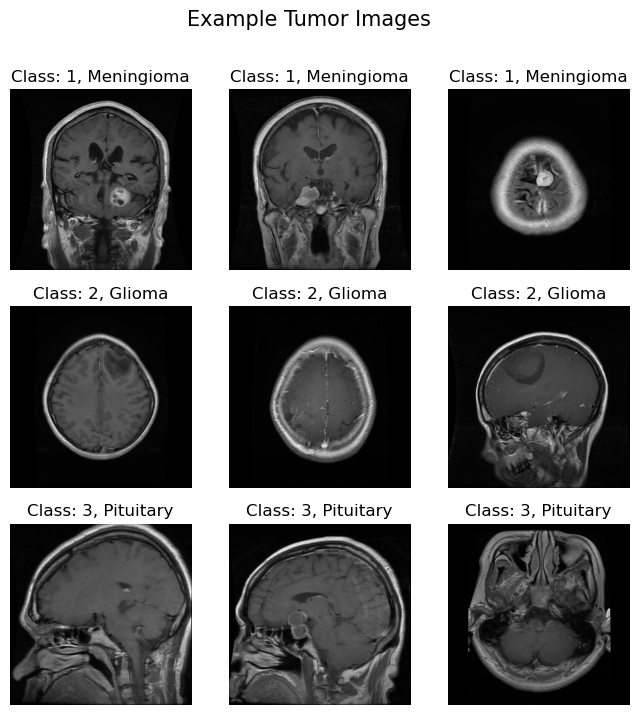

In [5]:
np.random.seed(seed=109)

class_1_indexes = np.arange(0,len(tumor_labels))[tumor_labels == 1]
class_2_indexes = np.arange(0,len(tumor_labels))[tumor_labels == 2]
class_3_indexes = np.arange(0,len(tumor_labels))[tumor_labels == 3]

class_num = [1,1,1,2,2,2,3,3,3]
tumor_name = {1: 'Meningioma', 2: 'Glioma', 3: 'Pituitary'}

examples_idx = [*np.random.choice(class_1_indexes,3), *np.random.choice(class_2_indexes,3), *np.random.choice(class_3_indexes,3)] 


fig, axes = plt.subplots(3,3,figsize = (8,8))

axes = axes.ravel()

fig.suptitle('Example Tumor Images',fontsize = 15)

for cnum, ex_idx, ax in zip(class_num,examples_idx,axes):
    ax.imshow(tumor_images[:,:,ex_idx],cmap='gray')
    
    ax.set_title(f'Class: {cnum}, {tumor_name[cnum]}')
    ax.axis('off')
    
plt.show()

From this we are able to see the fMRI scan data that we are working with.  We can see that images are different degrees of zoomed in, different perspectives/angles, and sometimes rotated or oriented different; this will motivate using data augmentation techniques in modeling later on.

To understand the global scope of our data, we examine how many tumor images we have per tumor type.  The code below does this:

Each tumor type has the following number of images :



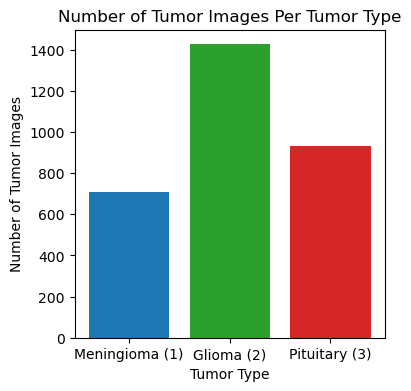

In [6]:
print(f'Each tumor type has the following number of images :\n')
tumor_types_count = {1: 0, 2:0, 3:0}
for lab in tumor_labels:
    tumor_types_count[lab] += 1

plt.figure(figsize = (4,4))
plt.bar(range(len(tumor_types_count)), tumor_types_count.values(), 
        tick_label=['Meningioma (1)','Glioma (2)','Pituitary (3)'],
        color = ['tab:blue', 'tab:green', 'tab:red'])
plt.title('Number of Tumor Images Per Tumor Type')
plt.xlabel('Tumor Type')
plt.ylabel('Number of Tumor Images')
plt.show()

Clearly, this is an imbalanced dataset with more Glioma images than meningioma and pituary images.  We will keep this in mind and may use upsampling to balanced our dataset later on.

We also want to see how many unique patients we have contributing images to our dataset.

In [7]:
set_PIDs = set(patient_ids)

print(f'There are {len(set_PIDs)} unique patient IDs\n')

There are 233 unique patient IDs



While basic summary statistics can teach us about values in the tumor image dataset, we can gain a deeper understanding from considering how the number of unique patients will affect our analysis; especially with regards to how we choose to split our data in the future.  There are 233 unique patients in the dataset but 3064 images.  On average, each patient contributes 13.2 images to the dataset. We can see the distribution how many patients contributed a given number of images by making a histogram.

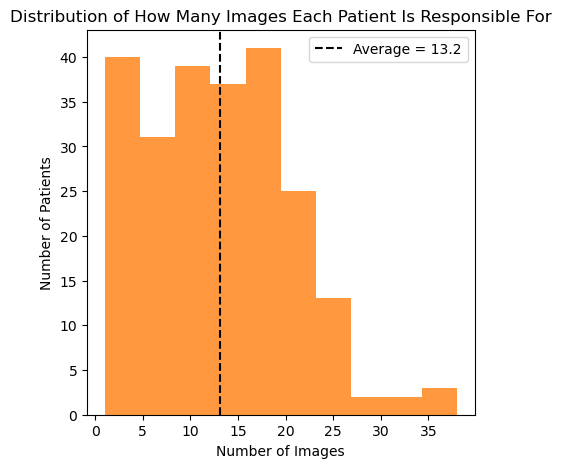

In [9]:
#recording how many images each patient produced
ims_per_id = {}
for id_ in set_PIDs:
    ims_per_id[id_] = list(patient_ids).count(id_)
    
patients_per_tumor_type = {1: [], 2: [], 3: []}
num_patients_per_tumor_type = {1: 0, 2: 0, 3: 0}

images_per_id_vals = np.array(list(ims_per_id.values()))

plt.figure(figsize = (5,5))
plt.hist(images_per_id_vals,color = 'tab:orange',alpha=0.8)
plt.axvline(images_per_id_vals.mean(), color = 'k', linestyle = '--',label = f'Average = {images_per_id_vals.mean():.1f}')    
plt.title('Distribution of How Many Images Each Patient Is Responsible For')
plt.xlabel('Number of Images')
plt.ylabel('Number of Patients')
plt.legend()
plt.show()

This histogram tells us that the overwhelming majority of patients are contributing between 0-20 images.  Additionally,there do not seem to be many patients with outlier values, as only a couple patients donated more than 25 images, which is not too extreme of an outlier to begin with.


Knowing this, we can visualize how images from the same patient may different in the datatset.  We can do this by displaying some examples of images from the same patient.

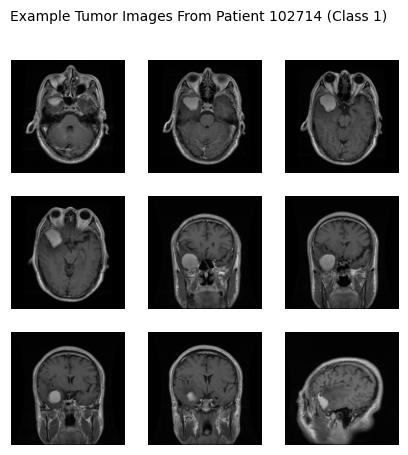

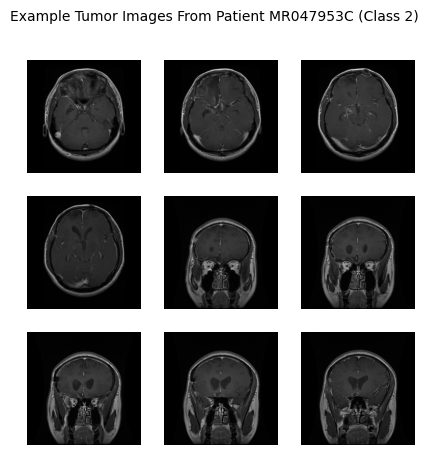

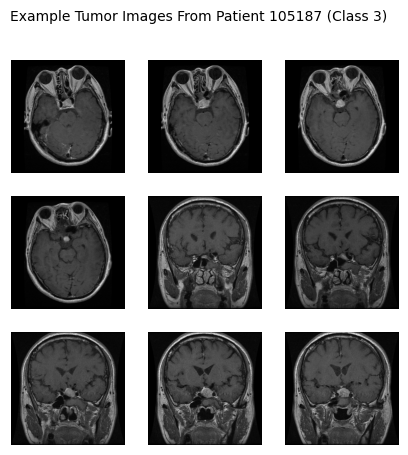

In [108]:
np.random.seed(seed=220)

#mapping certain patients to their corresponding tumor type
id_to_label_map = dict(zip([id_ for id_ in set_PIDs],[0]*len(set_PIDs)))
for i,id_ in enumerate(patient_ids):
    id_to_label_map[id_] = int(tumor_labels[i])


#recording how many patients contributed images for each tumor type
for key, value in id_to_label_map.items():
    patients_per_tumor_type[value].append(key)
    num_patients_per_tumor_type[value] += 1


c1_patient_ex = np.random.choice(patients_per_tumor_type[1])
c2_patient_ex = np.random.choice(patients_per_tumor_type[2])
c3_patient_ex = np.random.choice(patients_per_tumor_type[3])

for cla, patient in zip([1,2,3],[c1_patient_ex, c2_patient_ex, c3_patient_ex]):
    
    fig, axes = plt.subplots(3,3,figsize = (5,5))

    axes = axes.ravel()

    fig.suptitle(f'Example Tumor Images From Patient {patient.decode()} (Class {cla})',fontsize = 10)
    
    examples_by_patient = tumor_images[:,:,patient_ids == patient]

    for i, ax in zip(range(9),axes):
        ax.imshow(examples_by_patient[:,:,i],cmap='gray')
        ax.axis('off')

    plt.show()

Looking at these different samples from within a person for each tumor type we can see that many of the images are from slightly diffferent angles, with slightly different magnifications, or from different scanning planes.  This again points to needs for data augmentation as even within patients, many different angles and views are present in the dataset.

As we try to figure out where the imbalance in the dataset, with more Glioma images than Meningioma and Pituary images, we can plot the number of tumor images for each patient colored by tumor type to get more information.  The code for this seen below.

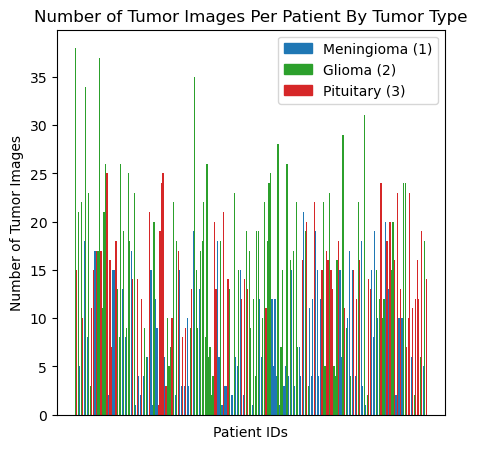

In [110]:
colors_map = dict(zip([1,2,3],['tab:blue','tab:green','tab:red']))
colors = [colors_map[id_to_label_map[id_]] for id_ in set_PIDs]


colors_leg = {'Meningioma (1)':'tab:blue', 'Glioma (2)':'tab:green', 'Pituitary (3)':'tab:red'}         
labels_leg = list(colors_leg.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors_leg[label]) for label in labels_leg]


plt.figure(figsize = (5,5))
plt.bar(range(len(ims_per_id)), ims_per_id.values(), tick_label=ims_per_id.keys(),
        color = colors)
plt.title('Number of Tumor Images Per Patient By Tumor Type')
plt.xlabel('Patient IDs')
plt.ylabel('Number of Tumor Images')
plt.xticks([])
plt.legend(handles, labels_leg)

plt.show()

 From this plot we can see that the overwhelming majority of patients with over 20 images in the set are glioma patients, with very few meningioma and pituitary tumor patients having this many images.  Additionally, many of the shortest bars, representing patients with fewer images in the set, appear to be meningioma patients.  This explains why glioma is so overrepresented in the data.  Not only are there the most glioma patients but they generally contribute a high number of images.
 
 
However, if we plot a bar plot of how many patients there are per tumor type we can gain even more information.  The code for this is shown below.

There 1476 unique patients in class 1
There 1602 unique patients in class 2
There 1116 unique patients in class 3


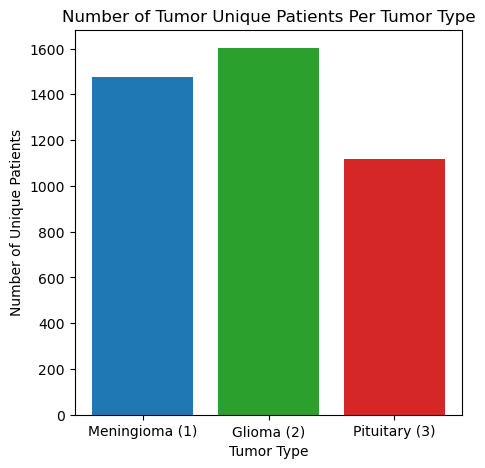

In [109]:
for key,value in num_patients_per_tumor_type.items():
    print(f'There {value} unique patients in class {key}')

plt.figure(figsize = (5,5))
plt.bar(range(len(num_patients_per_tumor_type)), num_patients_per_tumor_type.values(), 
        tick_label=['Meningioma (1)','Glioma (2)','Pituitary (3)'],
        color = ['tab:blue', 'tab:green', 'tab:red'])
plt.title('Number of Tumor Unique Patients Per Tumor Type')
plt.xlabel('Tumor Type')
plt.ylabel('Number of Unique Patients')
plt.show()

Here, we see that interestingly, even though there are more unique meningioma than pituitary patients in the dataset, there are actually fewer meningioma images than pituitary images. This points to the fact that on average, pituitary patients must contribute more images to the dataset than meningioma. We can confirm these results by looking at histograms of the distribution of how many patients contributed a certain number of images for each tumor type (shown below).

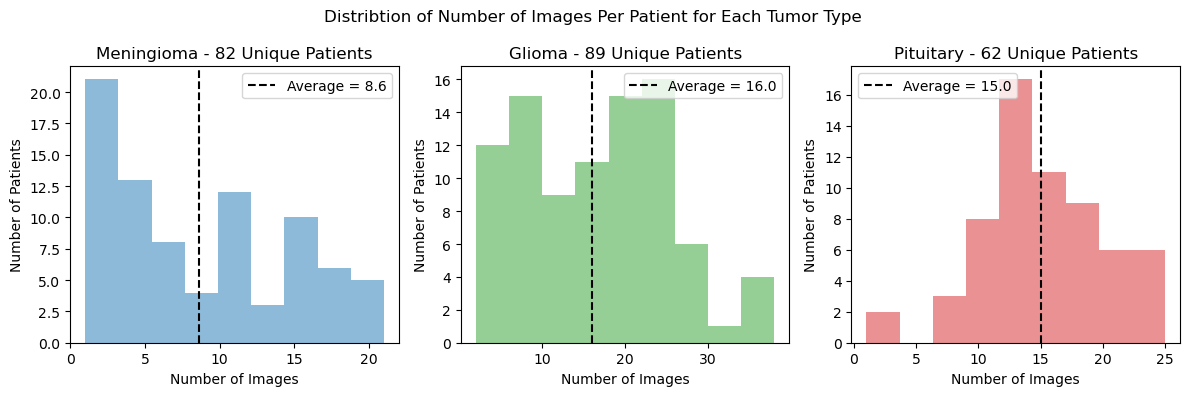

In [111]:
images_per_id_vals = np.array(list(ims_per_id.values()))

labels_per_patient = np.array(list(id_to_label_map.values()))

tumor_label_map = {1:'Meningioma',2:'Glioma',3:'Pituitary'}

fig, axs = plt.subplots(1,3, figsize = (12,4))
fig.suptitle('Distribtion of Number of Images Per Patient for Each Tumor Type ')
for lab, ax in zip(np.arange(1,4),axs):
    plot_vals = images_per_id_vals[labels_per_patient ==lab]
    ax.hist(plot_vals,bins =9,color = colors_map[lab],alpha=0.5)
    ax.axvline(plot_vals.mean(), color = 'k', linestyle = '--',label = f'Average = {plot_vals.mean():.1f}')    
    ax.set_title(f'{tumor_label_map[lab]} - {len(plot_vals)} Unique Patients')
    ax.set_xlabel('Number of Images')
    ax.set_ylabel('Number of Patients')
    ax.legend()
plt.tight_layout()
plt.show()

As we can see, on average meningioma patients contribute 8.6 images, glioma patients contribute 16.0 images, and pituitary patients contribute 15.0 images, to the dataset.

Now that we have conducted exploratory data analysis to understand the underlying patterns and relationships in the data, we need to prepare our data for modeling.


# Splitting the Data Into Train, Validation, and Test Sets

In order to train, validate, and test our model we will need to split our data. However, to match the use cases of a model in the real-world, we must ensure that that there are no patients who contribute images to both the train and the test cases (or validation).  We also must make sure that there are a relatively balanced split of images of each tumor in the train, validation, and test data sets.  We will also have to account for class inbalance.

There are 233 unique patients, each contributing to images to one of the tumor classes, and each contributing a different number of images to the dataset.  In this scenario, a simple random split of images to create train, validation, and testing splits would result in serious data leakage as we would be using images from the same patient in both the train and testing set.  In a real-world situation this is highly unrealistic.  Therefore,  rather than randomly splitting on images, we do a random split on patient ID to determine which patients will be in the training set, the validation set, and the testing set.  Once we have established which patients will be part of each set, then we add their respective images to each of the sets.  This method ensures that there is no overlap of patients between the sets.  We use 25% of the patients for testing, 15% of the patients for validation, and 60% of the patients for training. Because we have imbalanced classes (more on this below), we also stratify the random patient splits by the tumor class, ensuring that we do not get random splits with disp This gives us spits with 1871 images used for training, 399 images used for validation, and 794 images used for testing. There are 452 class 1 tumor images, 872 class 2 tumor images, and 547 class 3 tumor images in the training data. There are 76 class 1 tumor images, 204 class 2 tumor images, and 119 class 3 tumor images in the validation data. There are 180 class 1 tumor images, 350 class 2 tumor images, and 264 class 3 tumor images in the testing data.roportionate amounts of patients of one class, relative to the data. The code to do this is shown below.

First we split the patients randomly into 3 groups – train, validation, and test - stratifying by tumor classification:

In [132]:
train_and_valid_patient_ids, test_patient_ids = train_test_split(list(id_to_label_map.keys()),
                                                    test_size = 0.25,
                                                    random_state = 209,
                                                    shuffle = True,
                                                    stratify = list(id_to_label_map.values()))


train_and_valid_labels = [id_to_label_map[id_] for id_ in train_and_valid_patient_ids]

train_patient_ids, valid_patient_ids = train_test_split(train_and_valid_patient_ids,
                                                    test_size = 0.2,
                                                    random_state = 209,
                                                    shuffle = True,
                                                    stratify = train_and_valid_labels)

train_patient_labels = np.array([id_to_label_map[id_] for id_ in train_patient_ids])
valid_patient_labels = np.array([id_to_label_map[id_] for id_ in valid_patient_ids])
test_patient_labels = np.array([id_to_label_map[id_] for id_ in test_patient_ids])



print(f'\nThere are {len(train_patient_ids)} patients being used for training.')
print(f'There are {len(valid_patient_ids)} patients being used for validation.')
print(f'There are {len(test_patient_ids)} patients being used for testing.\n\n')

print(f'There are {len(train_patient_labels[train_patient_labels==1])} class 1 tumor patients, \
{len(train_patient_labels[train_patient_labels==2])} class 2 tumor patients, and \
{len(train_patient_labels[train_patient_labels==3])} class 3 tumor patients in the training data.\n')

print(f'There are {len(valid_patient_labels[valid_patient_labels==1])} class 1 tumor patients, \
{len(valid_patient_labels[valid_patient_labels==2])} class 2 tumor patients, and \
{len(valid_patient_labels[valid_patient_labels==3])} class 3 tumor patients in the validation data.\n')

print(f'There are {len(test_patient_labels[test_patient_labels==1])} class 1 tumor patients, \
{len(test_patient_labels[test_patient_labels==2])} class 2 tumor patients, and \
{len(test_patient_labels[test_patient_labels==3])} class 3 tumor patients in the test data.')


There are 139 patients being used for training.
There are 35 patients being used for validation.
There are 59 patients being used for testing.


There are 49 class 1 tumor patients, 53 class 2 tumor patients, and 37 class 3 tumor patients in the training data.

There are 12 class 1 tumor patients, 14 class 2 tumor patients, and 9 class 3 tumor patients in the validation data.

There are 21 class 1 tumor patients, 22 class 2 tumor patients, and 16 class 3 tumor patients in the test data.




Now that we have the patients being used for training, validation, and test separated, we can see how many tumor images we will have in each set.

In [133]:
num_train_images = 0
num_test_images = 0
num_valid_images = 0
train_image_labels_count = dict(zip([1,2,3],[0,0,0]))
valid_image_labels_count = dict(zip([1,2,3],[0,0,0]))
test_image_labels_count = dict(zip([1,2,3],[0,0,0]))



for id_ in train_patient_ids:
    
    num_train_images += len(patient_ids[patient_ids == id_])
    
    train_image_labels_count[id_to_label_map[id_]] += len(patient_ids[patient_ids == id_])
    
for id_ in valid_patient_ids:
    
    num_valid_images += len(patient_ids[patient_ids == id_])
    
    valid_image_labels_count[id_to_label_map[id_]] += len(patient_ids[patient_ids == id_])

for id_ in test_patient_ids:
    
    num_test_images += len(patient_ids[patient_ids == id_])
    
    test_image_labels_count[id_to_label_map[id_]] += len(patient_ids[patient_ids == id_])
    

print(f'\nThere are {num_train_images} images being used for training.')
print(f'There are {num_valid_images} images being used for validation.')
print(f'There are {num_test_images} images being used for testing.\n\n')

print(f'There are {train_image_labels_count[1]} class 1 tumor images, \
{train_image_labels_count[2]} class 2 tumor images, and \
{train_image_labels_count[3]} class 3 tumor images in the training data.\n')

print(f'There are {valid_image_labels_count[1]} class 1 tumor images, \
{valid_image_labels_count[2]} class 2 tumor images, and \
{valid_image_labels_count[3]} class 3 tumor images in the validation data.\n')

print(f'There are {test_image_labels_count[1]} class 1 tumor images, \
{test_image_labels_count[2]} class 2 tumor images, and \
{test_image_labels_count[3]} class 3 tumor images in the testing data.\n')


There are 1847 images being used for training.
There are 490 images being used for validation.
There are 727 images being used for testing.


There are 419 class 1 tumor images, 857 class 2 tumor images, and 571 class 3 tumor images in the training data.

There are 97 class 1 tumor images, 271 class 2 tumor images, and 122 class 3 tumor images in the validation data.

There are 192 class 1 tumor images, 298 class 2 tumor images, and 237 class 3 tumor images in the testing data.



Clearly there is an inbalance in the number of tumor images per class.  We will keep this in mind when evaluating our model later on.  If model performance looks to be significantly worse on the underrepresented classes than we can investigate using techniques like upsampling to balance the dataset.

# Setting Up Data in Local Directory Structure For Modeling

Now that we know which images will belong in the train set, the validation set, and the test set, we have to set up our local directory structure with the image data that we will be using. Because we will be using the Keras ImageDataGenerator to load in the data efficiently during our modeling we need to organize the files on our computer in the following manner:

```
data/data_splits
 ├── test
 │   ├── Meningioma
 │   ├── Glioma
 │   └── Pituitary
 ├── train
 │   ├── Meningioma
 │   ├── Glioma
 │   └── Pituitary
 └── validation
     ├── Meningioma
     ├── Glioma
     └── Pituitary
```

The following code cell will accomplish that, saving each image as a .jpeg in its corresponding directory (note: the code assumes that you have already created a data splits folder with empty train, validation, and test, folders within it. We also keep track of which images we are adding to each directory in case we want to perform oversampling later. Again, we also normalize all the images to have pixel values from 0 to 255 so they can be represented as 8bit integers and can be easily rescaled by DataImageGenerator later.

In [145]:
set_train_patient_ids = set([id_.decode() for id_ in train_patient_ids])
set_valid_patient_ids = set([id_.decode() for id_ in valid_patient_ids])
set_test_patient_ids = set([id_.decode() for id_ in test_patient_ids])


image_nums_in_each_split = {'train_Meningioma': [],
                            'train_Glioma': [],
                            'train_Pituitary': [],
                            'validation_Meningioma': [],
                            'validation_Glioma': [],
                            'validation_Pituitary': [],
                            'test_Meningioma': [],
                            'test_Glioma': [],
                            'test_Pituitary': []}

data_folders = ['1-766', '767-1532', '1533-2298', '2299-3064']
image_numbers = [[x for x in range(1,767)],
              [x for x in range(767,1533)],
              [x for x in range(1533,2299)],
              [x for x in range(2299,3065)]]



for f, im_nums in zip(data_folders,image_numbers):
    for im_num in tqdm(im_nums):
        mat = loadmat(f'data/brainTumorDataPublic_{f}/{im_num}.mat')
        
        if mat['cjdata']['PID'] in set_train_patient_ids:
            dir1 = 'train'
        
        elif mat['cjdata']['PID'] in set_valid_patient_ids:
            dir1 = 'validation'
        
        elif mat['cjdata']['PID'] in set_test_patient_ids:
            dir1 = 'test'
        
        dir2 = tumor_label_map[int(mat['cjdata']['label'])]
        
        norm_image = cv2.normalize(mat['cjdata']['image'],
                                   None, alpha = 0, beta = 255,
                                   norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)

        norm_image = norm_image.astype(np.uint8)
        
        if norm_image.shape == (512, 512):
            count_512 += 1
        else:
            count_256 += 1
            
        image_nums_in_each_split[f'{dir1}_{dir2}'].append(im_num)
            
        im = Image.fromarray(norm_image)
        
        #im.save(f'data/data_splits/{dir1}/{dir2}/{im_num}.jpeg')


100%|████████████████████████████████████████| 766/766 [00:05<00:00, 151.53it/s]


In [147]:
np.random.seed(109)

for key, im_nums in image_nums_in_each_split.items():
    
    split, class_ = key.split('_')
    
    print(f'The {class_} images in the {split} set are: {np.random.choice(im_nums,4)}...\n')

The Meningioma images in the train set are: [439 421 421 227]...

The Glioma images in the train set are: [2296 2656 2959 2112]...

The Pituitary images in the train set are: [1486 1465 1662 1822]...

The Meningioma images in the validation set are: [139  99 495 659]...

The Glioma images in the validation set are: [1871 2523 2028  729]...

The Pituitary images in the validation set are: [ 990 1276  937  990]...

The Meningioma images in the test set are: [172 451 571 471]...

The Glioma images in the test set are: [1864 2507 2493 2778]...

The Pituitary images in the test set are: [ 714 1007  980 1487]...



# Baseline Logistic Regression Model

As this is a classification task, for our baseline model we implement a baseline logistic regression.  Logistic regression are quick-to-fit and highly interpretable models.  While we plan to implement several more complex neural-network based models, the simplicity and transparency of the baseline logistic regression model makes it a reference for comparison. Here, we fit the basic logistic regression on the (unbalanced) training + validation data and evaluate it on the test data.  We flatten the (512,512) images into a one-dimensional (262144) input – plus the addition of an intercept term – and fit the logistic regression with no regularization (note, because a logistic regression is essentially the same as a single dense layer with a softmax activation, we use this representation here in order to better utilize keras functionality). We examine the metrics of accuracy, precision, recall, and f-score.

## Baseline Model Fitting

First we create the  X_train, y_train, X_test, y_test arrays for use with the sklearn Logistic Regression function.  We load in the images from their respective directories that we created earlier, flatten them, and add them to the arrays. The code below does this.

In [2]:
num_train_images = 1847
num_valid_images = 490
num_test_images = 727

sets = ['train', 'validation']
classes = ['Meningioma', 'Glioma', 'Pituitary']


X_train = np.zeros((num_train_images + num_valid_images, 512*512),dtype = np.int8)
y_train = np.zeros(num_train_images + num_valid_images,dtype = np.int8)


i = 0
for s in sets:
    for c in classes:        
        
        files =  Path(f'data/data_splits/{s}/{c}').glob('*')
        for file in files:
            
            if str(file)[-5:] == '.jpeg':
                im = np.asarray(Image.open(str(file)))
                if im.shape == (256, 256):
                    im = np.array(Image.fromarray(im).resize((512,512)))

                X_train[i,:] = im.flatten()

                if c == 'Meningioma':
                    y_train[i] = 0
                if c == 'Glioma':
                    y_train[i] = 1
                if c == 'Pituitary':
                    y_train[i] = 2

                i += 1


X_test = np.zeros((num_test_images, 512*512),dtype = np.int8)
y_test = np.zeros(num_test_images,dtype = np.int8)

j = 0
for c in classes:
    
    files =  Path(f'data/data_splits/test/{c}').glob('*')
    
    for file in files:
        
        if str(file)[-5:] == '.jpeg':
            im = np.asarray(Image.open(str(file)))
            if im.shape == (256, 256):
                im = np.array(Image.fromarray(im).resize((512,512)))

            X_test[j,:] = im.flatten()

            if c == 'Meningioma':
                y_test[j] = 0
            if c == 'Glioma':
                y_test[j] = 1
            if c == 'Pituitary':
                y_test[j] = 2
            j += 1


Here we check the shape of our arrays before fitting the logistic regression model.

In [3]:
print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_test shape', X_test.shape)
print('y_test shape', y_test.shape)

X_train shape (2337, 262144)
y_train shape (2337,)
X_test shape (727, 262144)
y_test shape (727,)


Then we fit the baseline logistic regression model.

In [ ]:
logreg = LogisticRegression(penalty = None, fit_intercept=True, random_state = 109)
logreg.fit(X_train,y_train)

Here we include code to save the baseline model so we do not have to refit it every time we want to access it.

In [9]:
#logreg_model_path = 'models/baseline/baseline_logreg.pkl'

# with open(logreg_model_path, 'wb') as file:
#     pickle.dump(logreg, file)
    
# with open(logreg_model_path, 'rb') as file:
#     logreg = pickle.load(file)


## Baseline Model Results

Now we can look at metrics to determine how the baseline model performed.

The train accuracy of the baseline logistic regression model is: 1.00


The test accuracy of the baseline logistic regression model is: 0.72


The precision, recall, and fscore for each class is:

              precision    recall  f1-score   support

  Meningioma       0.59      0.33      0.42       192
      Glioma       0.65      0.86      0.74       298
   Pituitary       0.90      0.86      0.88       237

    accuracy                           0.72       727
   macro avg       0.71      0.68      0.68       727
weighted avg       0.71      0.72      0.70       727



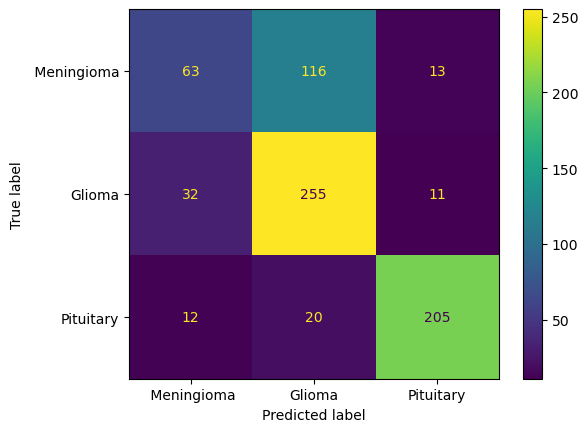

In [48]:
print(f'The train accuracy of the baseline logistic regression model is: {logreg.score(X_train, y_train):.2f}\n\n')
print(f'The test accuracy of the baseline logistic regression model is: {logreg.score(X_test, y_test):.2f}\n\n')
print('The precision, recall, and fscore for each class is:\n')

y_test_preds = logreg.predict(X_test)

print(classification_report(y_test, y_test_preds, target_names = [' Meningioma', 'Glioma', 'Pituitary']))

cm = ConfusionMatrixDisplay.from_predictions(y_test,
                                            y_test_preds,
                                            display_labels = [' Meningioma', 'Glioma', 'Pituitary'])



Interpretting the results of the baseline model, a couple things become apparrent.  First we can notice that the model is overfitting; while the training accuracy is 1.00, the test accuracy is only 0.72.  We can also notice that the model performs best – in terms of precision, recall, and f1-score – at predicting pituitary tumors.  The model also does fairly well at predicting glioma tumors but the precision is only 0.65.  Compared to the other two, the model performs poorly at predicting meningioma tumors, with a precision of 0.59, a recall of 0.33, and a f1-score of 0.442.  Meningioma has the smallest support of all the classes and the dataset is quite unbalanced.  The drastically lower f1-score for this class compared to the others indicates that balancing the dataset using upsampling will likely improve the model.

Generally, our logistic regression model cannot utilize much of the image specific pixel relations that could allow for better classification because we are forced flatten the pixels when passing the data to the model.  It is likely that a model built for extracting and using information from images could perform better.  Therefore, we decide to use CNN architectures to build our final models. 

# Image Data Generator Pipeline For CNN Models

With the directory structure set up as shown early, we can create the image data generators that will be used to load data into our CNN models.  We will have _multiple_ generators, one for each split directory.</br>


First we create a a main data generator object, `datagen`. Later it will be given a wide range of arguments which will be used to preprocess the images it generates.</br>

We use it first to normalize all pixel values to between 0 and 1 as they are stored with pixels shaded from 0 to 255).</br>
We also will resize all images to 512 by 512 because, in the raw data, 3049 images are 512 by 512 images and 15 images 256 by 256 images.

In [4]:
datagen = ImageDataGenerator(rescale=1./255)
DATA_DIR = 'data_splits2023' # create path name for data

Next we create a generator for each split directory.  Here we also define our batch size and the target size (which all images will be resized to meet). Note, we use a batch size of 1 for the testgenerator so we can make single predictions at a time if we want to.

In [6]:
batch_size = 32
target_size = (512, 512) # generator resizes all images if we want
# this is the augmentation configuration we will use for training

traingen = datagen.flow_from_directory(
                                DATA_DIR+'/train', 
                                target_size=target_size,  
                                batch_size=batch_size,
                                class_mode='categorical', 
                                 color_mode='grayscale')
valgen = datagen.flow_from_directory(
                                DATA_DIR+'/validation',
                                target_size=target_size, 
                                batch_size=batch_size,
                                class_mode='categorical',
                                color_mode='grayscale') 

testgen = datagen.flow_from_directory(
                        DATA_DIR+'/test',  
                        target_size=target_size, 
                        batch_size=1,
                        shuffle = False,
                        class_mode='categorical',
                        color_mode='grayscale') 

Found 1847 images belonging to 3 classes.
Found 490 images belonging to 3 classes.
Found 727 images belonging to 3 classes.


To make sure we are on the right track we can check the dimensions of one batch of data.

In [7]:
data_batch, labels_batch = next(traingen)
print('data batch shape:', data_batch.shape)
print('labels batch shape:', labels_batch.shape)
print('class indices:', traingen.class_indices)

data batch shape: (32, 512, 512, 1)
labels batch shape: (32, 3)
class indices: {'Glioma': 0, 'Meningioma': 1, 'Pituitary': 2}


This is what we expected.  There are batch_size images in the batch.  Each image is 512 by 512.  And, because our image is grey-scale, there is only one color channel.  The labels have dimension (batch_size, 3) as we can 3 classes and the labels are one hot encoded.

# Basic CNN Model

Now that we have a data generators we can create our CNN models.

## Basic CNN Model Fitting

First we fit a basic CNN model to see if it leads to improvements over the baseline logistic regression. 

In [8]:
input_dim = data_batch.shape[1:]
n_classes = labels_batch.shape[-1]


inputs = Input(shape=(input_dim))

x = Conv2D(64, 3, padding='valid', activation="relu")(inputs)
x = MaxPool2D((3,3))(x)
x = Conv2D(32, 3, padding='valid', activation="relu")(x)
x = MaxPool2D((3,3))(x)
x = Conv2D(32, 3, padding='valid', activation="relu")(x)
x = MaxPool2D((3,3))(x)
x = Flatten()(x)
x = Dense(32, activation="relu")(x)
outputs = Dense(n_classes, activation="softmax")(x)



sample_model = Model(inputs=inputs, outputs=outputs, name="sample")

sample_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
sample_model.summary()

2023-05-08 01:20:59.949562: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-08 01:21:06.380232: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-08 01:21:06.380556: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sample"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 510, 510, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 170, 170, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 168, 168, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 54, 54, 32)        9248 

We can get a flowchart of the model using the following code. It will be a png saved in our lcoal directory.  Our presentation includes examples of these flowcharts for the different models we tried.

In [ ]:
tf.keras.utils.plot_model(sample_model, to_file="basic_cnn.png")

We use early stopping to stop training if there is no improvement in validation loss.

In [9]:
es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
callbacks = [es]

Then we fit the model we defined previously.

In [26]:
history = sample_model.fit(
        traingen,
        steps_per_epoch=traingen.samples//traingen.batch_size,
        epochs=30,
        validation_data=valgen,
        validation_steps=valgen.samples//valgen.batch_size,
        callbacks=callbacks,
        workers=-1,
        use_multiprocessing=True,
        verbose=1)

Epoch 1/30


2023-04-24 00:25:31.781445: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - ETA: 0s - loss: 0.8305 - accuracy: 0.6198

2023-04-24 00:25:45.226364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 15s 208ms/step - loss: 0.8305 - accuracy: 0.6198 - val_loss: 0.5704 - val_accuracy: 0.7271
Epoch 2/30
57/57 [==============================] - 11s 183ms/step - loss: 0.5503 - accuracy: 0.7647 - val_loss: 0.6400 - val_accuracy: 0.6729
Epoch 3/30
57/57 [==============================] - 10s 181ms/step - loss: 0.3909 - accuracy: 0.8380 - val_loss: 0.5040 - val_accuracy: 0.7667
Epoch 4/30
57/57 [==============================] - 11s 184ms/step - loss: 0.3066 - accuracy: 0.8727 - val_loss: 0.5445 - val_accuracy: 0.7625
Epoch 5/30
57/57 [==============================] - 10s 181ms/step - loss: 0.2114 - accuracy: 0.9107 - val_loss: 0.4629 - val_accuracy: 0.7917
Epoch 6/30
57/57 [==============================] - 11s 184ms/step - loss: 0.1302 - accuracy: 0.9515 - val_loss: 0.5122 - val_accuracy: 0.8083
Epoch 7/30
57/57 [==============================] - 10s 182ms/step - loss: 0.0646 - accuracy: 0.9769 - val_loss: 0.8707 - val_accuracy: 0.7896
Epoch 8/30

We can then plot the loss and accuracy of our model as it trained.

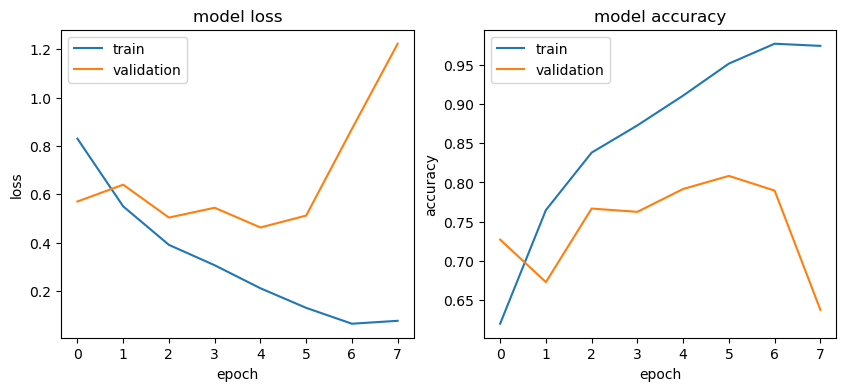

In [27]:
fig, axs = plt.subplots(1,2, figsize=(10,4))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].set_title('model loss')
axs[0].set_ylabel('loss')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'validation'], loc='upper left')

# summarize history for loss
axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].set_title('model accuracy')
axs[1].set_ylabel('accuracy')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'validation'], loc='upper left');

## Basic CNN Model Results

We can look at the training, validation, and test accuracy of our model.

In [28]:
print(f'This sample model has traning accuracy : {sample_model.evaluate(traingen,verbose=0)[-1]}\n')
print(f'This sample model has validation accuracy : {sample_model.evaluate(valgen,verbose=0)[-1]}\n')
print(f'This sample model has testing accuracy : {sample_model.evaluate(testgen,verbose=0)[-1]}\n')

2023-04-24 00:27:01.114281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


This sample model has traning accuracy : 0.9545208215713501



2023-04-24 00:27:07.028145: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


This sample model has validation accuracy : 0.7938775420188904



2023-04-24 00:27:08.860516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


This sample model has testing accuracy : 0.810178816318512



We can also look at the same precision, recall, and f1-score metrics for each class to compare our CNN to the baseline logistic regression

/tmp/ipykernel_3153/144594819.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_test_probas = sample_model.predict_generator(testgen,steps = len(testgen.labels))
2023-04-24 00:27:11.330570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


              precision    recall  f1-score   support

      Glioma       0.78      0.81      0.79       298
  Meningioma       0.74      0.58      0.65       192
   Pituitary       0.89      1.00      0.94       237

    accuracy                           0.81       727
   macro avg       0.80      0.80      0.79       727
weighted avg       0.80      0.81      0.80       727



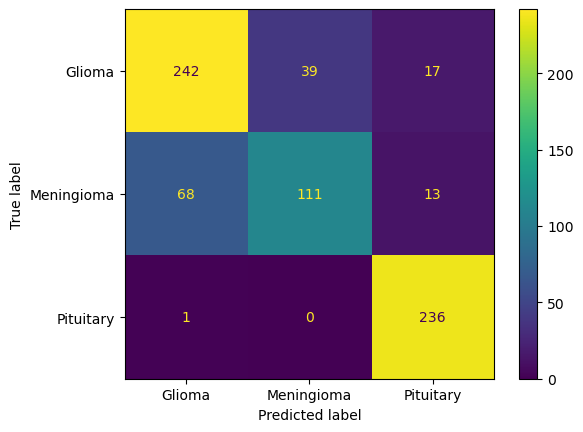

In [29]:
y_test_probas = sample_model.predict_generator(testgen,steps = len(testgen.labels))
y_test_preds = y_test_probas.argmax(1)
y_test = testgen.labels

print(classification_report(y_test, y_test_preds, target_names = ['Glioma', 'Meningioma', 'Pituitary']))

cm = ConfusionMatrixDisplay.from_predictions(y_test,
                                            y_test_preds,
                                            display_labels = ['Glioma', 'Meningioma', 'Pituitary'])


Already, even with this very basic CNN architecture we see heavy improvements compared to our baseline logistic regression.  This indicates that the CNN architecture was a good choice.  With data augmentation, hyperparameter tuning, class balancing, and architecture tuning, it is likely we can even get far better results with CNNs.


Comparing the values of key metrics for the sample CNN vs logistic regression reveals better performance in all manners.
```
The test accuracy of the baseline logistic regression model is: 0.72
The test accuracy of the sample CNN model is 0.81



```




```
Baseline Logistic Regression

                      precision    recall  f1-score   support

          Meningioma       0.59      0.33      0.42       192
              Glioma       0.65      0.86      0.74       298
           Pituitary       0.90      0.86      0.88       237
   
   
Sample CNN   
                        precision    recall  f1-score   support

          Meningioma       0.74      0.58      0.65       192
              Glioma       0.78      0.81      0.79       298

           Pituitary       0.89      1.00      0.94       237
           
           
           
           
```

We can see that the precision, recall, and f1-scores for all classes are better with the CNN model.  One thing to note is that while all these scores is better, we still see that our model is performing better with pituitary than glioma and meningioma samples.  This again points to the fact that some upsampling is needed to balance the dataset.  More complex models cannot make up for the fact that the data is so unbalanced.

# Upsampling to Balance Classes in the Training Data

From the precision, recall, and f1-score metrics, we can see that our basic CNN model is performing better on pituitary than glioma and meningioma samples.  This could be due to the class imbalance in the dataset; there are 419 meningioma tumor images, 857 glioma tumor images, and 571 pituitary tumor images in the training data. 

We would ideally like there to be an equal or relatively equal number of of images per class in the training set. We can do this by upsampling images. To balance the classes in each set we will need to upsample the number of meningioma and pituitary images in each set to match the number of glioma images. First we duplicate the train directory and call it train_balanced.  Then we add randomly sampled images from the minority classes to the minority folders within the train_balanced directory.  In the end, this will lead to an equal amount of images for each class in the training set train_balanced.  The code below does this class balancing (assuming the train directory has already been duplicated and renamed to train_balanced).

In [38]:
np.random.seed(109)

#getting a list of which image numbers are in the training splits for each tumor type
labels = ['Meningioma', 'Glioma', 'Pituitary']
train_im_nums = {lab: [] for lab in labels}

for lab in labels:
    files =  Path(f'data/data_splits2023/train/{lab}').glob('*')
    for file in files:
        if str(file)[-5:] == '.jpeg':
            train_im_nums[lab].append(int(str(file).split('/')[-1][:-5]))


#figuring out how many images to upsample to balance classes
num_upsample_class1 = len(train_im_nums['Glioma']) - len(train_im_nums['Meningioma'])
num_upsample_class3 = len(train_im_nums['Glioma']) - len(train_im_nums['Pituitary'])

#randomly choosing images to upsample to balance classes
upsampled_im_nums_class_1p1 = train_im_nums['Meningioma']
upsampled_im_nums_class_1p2 = np.random.choice(train_im_nums['Meningioma'],
                                             size = num_upsample_class1 - len(upsampled_im_nums_class_1p1),
                                             replace=False)

upsampled_im_nums_class_3 = np.random.choice(train_im_nums['Pituitary'],
                                             size = num_upsample_class3,
                                             replace=False)



#for every upsampled image, add it to the train balanced directory for both tumor types that were upsampled
for im_num in upsampled_im_nums_class_1p1:
    
    im = Image.open(f'data/data_splits2023/train/Meningioma/{im_num}.jpeg')
    #im.save(f'data/data_splits2023/train_balanced/Meningioma/{im_num}_upsampled.jpeg')

for im_num in upsampled_im_nums_class_1p2:
    
    im = Image.open(f'data/data_splits2023/train/Meningioma/{im_num}.jpeg')
    #im.save(f'data/data_splits2023/train_balanced/Meningioma/{im_num}_upsampled_.jpeg')
    

for im_num in upsampled_im_nums_class_3:
    
    im = Image.open(f'data/data_splits2023/train/Pituitary/{im_num}.jpeg')
    #im.save(f'data/data_splits2023/train_balanced/Pituitary/{im_num}_upsampled.jpeg')

After this upsampling we have the following directory structure:

```
data/data_splits2023
 ├── test
 │   ├── Meningioma
 │   ├── Glioma
 │   └── Pituitary
 │
 ├── train
 │   ├── Meningioma
 │   ├── Glioma
 │   └── Pituitary
 │
 ├── train_balanced
 │   ├── Meningioma
 │   ├── Glioma
 │   └── Pituitary
 │
 └── validation
     ├── Meningioma
     ├── Glioma
     └── Pituitary
```
Unlike train, the train_balanced directory has an equal number of images per class (857 for all classes), as we upsampled images from Meningioma and Pituitary for them to have the same number as Glioma.  This was all done while still ensuring the different patients were used for training, validation, and testing.

# Data Augmentation

Something else that would likely improve our model is having more data.  Because this is not an option in this case, the best we can do is simulate new data, by creating variants of our original data; this is called data augmentation.  By doing this to our training data or model becomes less likely to overfit.

In the case of images this is very intuitive. Simply rotate your picture of a horse. It's still a horse, but the rotated image is likely different from anything in your data original. As long as the simulated data is not *too* different from the sort of example's we'd like to learn, this can help our model generalize better to previously unseen examples not in the original dataset.

From the example images we displayed during EDA, we can see that tumor images are taken often with small deviations in the angle of the image, how much the image is zoomed in, and what side the tumor is on.  This indicates that we should do data augmentation with a small random rotation applied to images, small random zoom-ins, and random horizontal flips of the images.  We can easily do these transformations for inside the image data generator, as shown below.

In [24]:
datagen_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest')

# CNN Model Trained With Data Augmentation and the Balanced Dataset

First, we have to redefine our training data generator as we now want it to pull from the balanced training set rather than the unbalanced one and use the data generator with data augmentation applied. Note: we don't redefine our validation and test sets because we don't want to applied data augmentation to these sets.

In [25]:
traingen_balanced = datagen_aug.flow_from_directory(
                                DATA_DIR+'/train_balanced', 
                                target_size=target_size,  
                                batch_size=batch_size,
                                class_mode='categorical', 
                                 color_mode='grayscale')

Found 2571 images belonging to 3 classes.


Note: The train_balanced generator finds 2571 images (instead of 1847 images like the train generator) because now the classes are balanced such that there is 857 images for each class. This is what we expect.


Now that we have the balanced training dataset and the corresponding augmented data generator, we can fit another CNN model with the same structure as the one before.  Our hope is that this model will perform better than the previous.

In [26]:
balanced_model = Model(inputs=inputs, outputs=outputs, name="balanced")

balanced_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
balanced_model.summary()

Model: "balanced"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 510, 510, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 170, 170, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 168, 168, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 54, 54, 32)        924

We fit the balanced training data model the same way we did with the previous, but now using the balanced data.

In [27]:
history = balanced_model.fit(
        traingen_balanced,
        steps_per_epoch=traingen_balanced.samples//traingen_balanced.batch_size,
        epochs=30,
        validation_data=valgen,
        validation_steps=valgen.samples//valgen.batch_size,
        callbacks=callbacks,
        workers=-1,
        use_multiprocessing=True,
        verbose=1)

Epoch 1/30


2023-05-08 01:53:27.598541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


80/80 [==============================] - ETA: 0s - loss: 0.3194 - accuracy: 0.8842

2023-05-08 01:54:14.166468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


80/80 [==============================] - 48s 582ms/step - loss: 0.3194 - accuracy: 0.8842 - val_loss: 0.4136 - val_accuracy: 0.8396
Epoch 2/30
80/80 [==============================] - 47s 581ms/step - loss: 0.2686 - accuracy: 0.9055 - val_loss: 0.3921 - val_accuracy: 0.8562
Epoch 3/30
80/80 [==============================] - 47s 587ms/step - loss: 0.2218 - accuracy: 0.9141 - val_loss: 0.4583 - val_accuracy: 0.8438
Epoch 4/30
80/80 [==============================] - 47s 583ms/step - loss: 0.1927 - accuracy: 0.9256 - val_loss: 0.3414 - val_accuracy: 0.8687
Epoch 5/30
80/80 [==============================] - 47s 581ms/step - loss: 0.1927 - accuracy: 0.9252 - val_loss: 0.5281 - val_accuracy: 0.8125
Epoch 6/30
80/80 [==============================] - 46s 578ms/step - loss: 0.1507 - accuracy: 0.9449 - val_loss: 0.3869 - val_accuracy: 0.8562
Epoch 7/30
80/80 [==============================] - 47s 586ms/step - loss: 0.1265 - accuracy: 0.9543 - val_loss: 0.8013 - val_accuracy: 0.7729


We can get a flowchart of the model using the following code. It will be a png saved in our lcoal directory.  Our presentation includes examples of these flowcharts for the different models we tried.

In [ ]:
tf.keras.utils.plot_model(balanced_model, to_file="balanced_data_aug_cnn.png")

We again plot the loss and accuracy of our model as it trained.

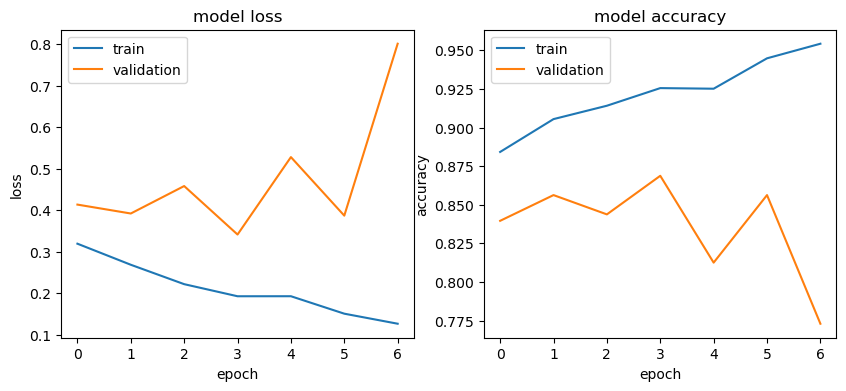

In [28]:
fig, axs = plt.subplots(1,2, figsize=(10,4))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].set_title('model loss')
axs[0].set_ylabel('loss')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'validation'], loc='upper left')

# summarize history for loss
axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].set_title('model accuracy')
axs[1].set_ylabel('accuracy')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'validation'], loc='upper left');

We can again look at the training, validation, and test accuracy of our model.

In [29]:
print(f'This balanced training data model has traning accuracy : {balanced_model.evaluate(traingen_balanced,verbose=0)[-1]}\n')
print(f'This balanced training data model has validation accuracy : {balanced_model.evaluate(valgen,verbose=0)[-1]}\n')
print(f'This balanced training data model has testing accuracy : {balanced_model.evaluate(testgen,verbose=0)[-1]}\n')

2023-05-08 01:58:57.512150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


This balanced training data model has traning accuracy : 0.9436017274856567



2023-05-08 01:59:41.622287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


This balanced training data model has validation accuracy : 0.8714285492897034



2023-05-08 01:59:43.262594: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


This balanced training data model has testing accuracy : 0.8514443039894104



This will save the model:

In [ ]:
#balanced_model.save('models/balance_dataaug_cnn')

We can also look at the same precision, recall, and f1-score metrics for each class and compare our balanced dataset with data augmentation CNN to the basic CNN and the baseline logistic regression.

/tmp/ipykernel_48/3761426723.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_test_probas = balanced_model.predict_generator(testgen,steps = len(testgen.labels))
2023-05-08 01:59:45.842444: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


              precision    recall  f1-score   support

      Glioma       0.83      0.86      0.85       298
  Meningioma       0.78      0.74      0.76       192
   Pituitary       0.93      0.93      0.93       237

    accuracy                           0.85       727
   macro avg       0.85      0.84      0.85       727
weighted avg       0.85      0.85      0.85       727



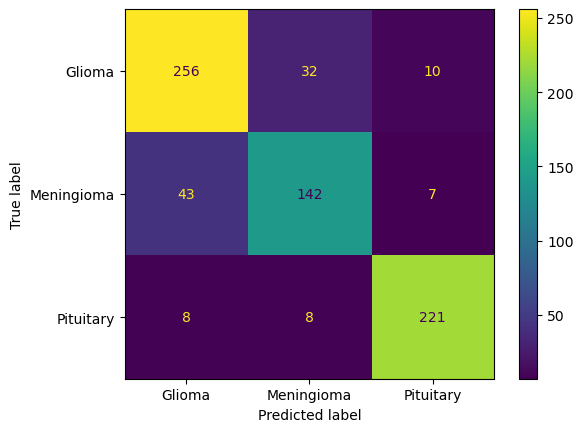

In [30]:
y_test_probas = balanced_model.predict_generator(testgen,steps = len(testgen.labels))
y_test_preds = y_test_probas.argmax(1)
y_test = testgen.labels

print(classification_report(y_test, y_test_preds, target_names = ['Glioma', 'Meningioma', 'Pituitary']))

cm = ConfusionMatrixDisplay.from_predictions(y_test,
                                            y_test_preds,
                                            display_labels = ['Glioma', 'Meningioma', 'Pituitary'])


Using data augmentation and upsampling to balance the datasets, we already see improvements in the model performance.  The test accuracy is now 0.85, compared to 0.81 with the basic CNN, and 0.72 with the logistic regression. In addition, we see that the model performs much better in terms of precision, recall, and f1-score than it did before. All three classes now have an f1-score above 0.75 when we use balanced training data with data augmentation, compared to with the logistic regression when 2 classes had f1-score below 0.75 and when we just used the basic CNN model where one class had an f1-score below 0.75.  Next, we look to improve these results by making big changes to the model architecture and weights, rather than just the input data.  For this we turn to transfer learning.

# Transfer Learning

Although we could continue to tweak our basic CNN architecture to obtain better and better results (and we did definitely do some tweaking!), rather than starting this process from scratch, we can use transfer learning (using models with pre-trained weights) to help solve our problem.  This apporach comes from the idea that earlier layers of a network learn low level features, which can be adapted to new domains by changing weights at later and fully-connected layers.  So, use pre-trained models to get representation of the low-level features of our tumor images, and then we will change weights at the final layers to best suit our tumor classification task.

# CNN Model with RESNET Base, Data Augmentation, and Balanced Classes

To use RESNET first we need to redfine our data generators but with rgb instead of grayscale because RESNET takes RGB inputs. This is done below.  We again want to use the augmentated data and balanced dataset. We also don't do any rescaling this time.

In [35]:
datagen = ImageDataGenerator()
datagen_aug = ImageDataGenerator(
    rotation_range=5,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest')

# Apply the transformations to the training data
traingen = datagen_aug.flow_from_directory(
    DATA_DIR+'/train_balanced', 
    target_size=target_size,  
    batch_size=batch_size,
    class_mode='categorical', 
    color_mode='rgb')

# Validation data should not be augmented
valgen = datagen.flow_from_directory(
    DATA_DIR+'/validation',
    target_size=target_size, 
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb') 

# Test data should not be augmented
testgen = datagen.flow_from_directory(
    DATA_DIR+'/test',  
    target_size=target_size, 
    batch_size=1,
    shuffle = False,
    class_mode='categorical',
    color_mode='rgb') 


Found 2571 images belonging to 3 classes.
Found 490 images belonging to 3 classes.
Found 727 images belonging to 3 classes.


This model uses ResNet50 as a base model and adds new layers for improved accuracy, including convolutional and fully connected layers with L2 regularization. A skip connection is also used, allowing the network to learn residual representations and prevent vanishing gradients. This is an important feature as it enables deeper networks to be trained more effectively. We hope that the model will achieves high accuracy on classifying brain tumor images task because of its innovative technique of combining ResNet50 with additional layers and the skip connection.

In [39]:
base_model4 = ResNet50(weights='imagenet', include_top=False, input_shape=(512,512,3))

#Freeze the base model layers

for layer in base_model4.layers:
    layer.trainable = False
#Add new layers

inputs = base_model4.input
x = Conv2D(64, 3, padding='same', activation="relu")(base_model4.output)
x = MaxPool2D((2,2))(x)
x = Conv2D(32, 3, padding='same', activation="relu")(x)
x = MaxPool2D((2,2))(x)
x = Flatten()(x)
x = Dense(32, activation="relu", kernel_regularizer=regularizers.l2(0.2))(x) # Add L2 regularization with lambda=0.2

skip = Conv2D(32, 3, padding='same', activation="relu")(base_model4.output)
skip = MaxPool2D((2,2))(skip)
skip = Flatten()(skip)
skip = Dense(32, activation="relu", kernel_regularizer=regularizers.l2(0.2))(skip) # Add L2 regularization with lambda=0.2


initial_learning_rate = 0.0005
decay_steps = 10000
decay_rate = 0.96
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps, decay_rate, staircase=True
)
adam = Adam(learning_rate=lr_schedule)

concatenated = Concatenate()([skip, x])
outputs = Dense(n_classes, activation="softmax")(concatenated)

model4 = Model(inputs=inputs, outputs=outputs)
model4.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model4.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

Here we fit the model:

In [40]:
history4 = model4.fit(
        traingen,
        steps_per_epoch=traingen.samples//traingen.batch_size,
        epochs=12,
        validation_data=valgen,
        validation_steps=valgen.samples//valgen.batch_size,
        callbacks=callbacks,
        workers=-1,
        use_multiprocessing=True,
        verbose=1)

Epoch 1/12


2023-05-08 02:17:51.216446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


80/80 [==============================] - ETA: 0s - loss: 15.8735 - accuracy: 0.7905

2023-05-08 02:20:09.096506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


80/80 [==============================] - 146s 2s/step - loss: 15.8735 - accuracy: 0.7905 - val_loss: 8.5010 - val_accuracy: 0.9104
Epoch 2/12
80/80 [==============================] - 135s 2s/step - loss: 5.6657 - accuracy: 0.9468 - val_loss: 3.8722 - val_accuracy: 0.8979
Epoch 3/12
80/80 [==============================] - 135s 2s/step - loss: 2.7649 - accuracy: 0.9764 - val_loss: 2.3146 - val_accuracy: 0.8854
Epoch 4/12
80/80 [==============================] - 135s 2s/step - loss: 1.6359 - accuracy: 0.9909 - val_loss: 1.5544 - val_accuracy: 0.8938
Epoch 5/12
80/80 [==============================] - 139s 2s/step - loss: 1.0735 - accuracy: 0.9909 - val_loss: 1.1971 - val_accuracy: 0.8875
Epoch 6/12
80/80 [==============================] - 136s 2s/step - loss: 0.7277 - accuracy: 0.9980 - val_loss: 0.7663 - val_accuracy: 0.9333
Epoch 7/12
80/80 [==============================] - 138s 2s/step - loss: 0.5159 - accuracy: 0.9965 - val_loss: 0.5858 - val_accuracy: 0.9312
Epoch 8/12
80/80 [=====

We can get a flowchart of the model using the following code. It will be a png saved in our lcoal directory.  Our presentation includes examples of these flowcharts for the different models we tried.

In [ ]:
tf.keras.utils.plot_model(model4, to_file="resnet_cnn.png")

Then we can plot the training history:

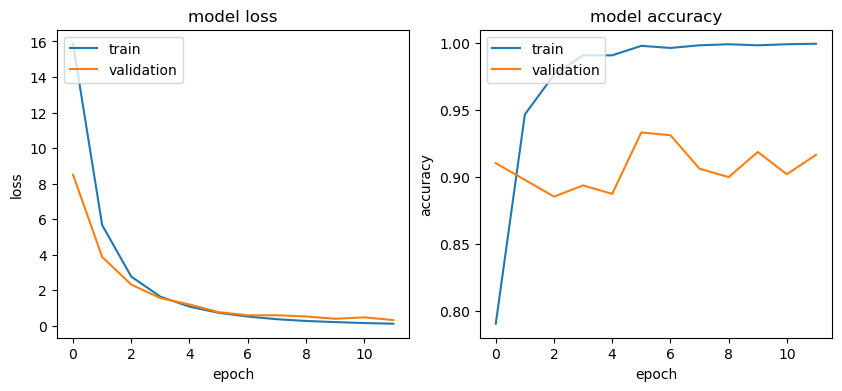

In [41]:
fig, axs = plt.subplots(1,2, figsize=(10,4))

axs[0].plot(history4.history['loss'])
axs[0].plot(history4.history['val_loss'])
axs[0].set_title('model loss')
axs[0].set_ylabel('loss')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'validation'], loc='upper left')

# summarize history for loss
axs[1].plot(history4.history['accuracy'])
axs[1].plot(history4.history['val_accuracy'])
axs[1].set_title('model accuracy')
axs[1].set_ylabel('accuracy')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'validation'], loc='upper left');

This will save the model:

In [42]:
#model4.save('models/resnet_transfer_learning')

INFO:tensorflow:Assets written to: models/resnet_transfer_learning/assets


INFO:tensorflow:Assets written to: models/resnet_transfer_learning/assets


We can again look at the training, validation, and test accuracy of our model.

In [43]:
print(f'This transfer learning base RESNET model has traning accuracy : {model4.evaluate(traingen,verbose=0)[-1]}\n')
print(f'This transfer learning base RESNET model has validation accuracy : {model4.evaluate(valgen,verbose=0)[-1]}\n')
print(f'This transfer learning base RESNET model has testing accuracy : {model4.evaluate(testgen,verbose=0)[-1]}\n')

2023-05-08 02:45:40.075352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


This transfer learning base RESNET model has traning accuracy : 1.0



2023-05-08 02:47:52.731307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


This transfer learning base RESNET model has validation accuracy : 0.9163265228271484



2023-05-08 02:48:01.933130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


This transfer learning base RESNET model has testing accuracy : 0.921595573425293



We can also look at the same precision, recall, and f1-score metrics for each class and compare our transfer learning RESNET model, with the balanced dataset + data augmentation CNN, basic CNN, and the baseline logistic regression.

/tmp/ipykernel_48/268655291.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_test_probas = model4.predict_generator(testgen,steps = len(testgen.labels))
2023-05-08 02:48:17.431500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


              precision    recall  f1-score   support

      Glioma       0.93      0.91      0.92       298
  Meningioma       0.85      0.86      0.86       192
   Pituitary       0.96      0.98      0.97       237

    accuracy                           0.92       727
   macro avg       0.92      0.92      0.92       727
weighted avg       0.92      0.92      0.92       727



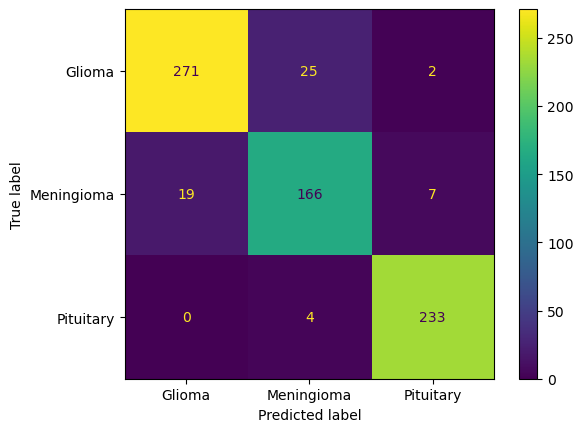

In [44]:
y_test_probas = model4.predict_generator(testgen,steps = len(testgen.labels))
y_test_preds = y_test_probas.argmax(1)
y_test = testgen.labels

print(classification_report(y_test, y_test_preds, target_names = ['Glioma', 'Meningioma', 'Pituitary']))

cm = ConfusionMatrixDisplay.from_predictions(y_test,
                                            y_test_preds,
                                            display_labels = ['Glioma', 'Meningioma', 'Pituitary'])


Here, again we can see improvements from past models.  Using transfer learning and a base of RESNET gave us accuracies of 0.92 on the test set, significantly higher (by at least 7%) than any of the other previous models.  This indicates that RESNET was able to successfully capture the low level features in our data before passing it to retrained final layers for classifications.  There is some overfitting that we can observe however.  With a 100% trainig accuracy, but only a 92% testing accuracy, the model is likely overfitting to noise in the training data.  On a positive note, however, we again see improvements in f1-score across all three tumor types, with scores all now over 0.85.        

# CNN Model with MobileNet Base, Data Augmentation, and Balanced Classes

As a point for comparison we also tried transfer learning using MobileNet a base model.  Although still having pretrained weights, MobileNet is a much smaller model than RESNET, if we can achieve good results using transfer learning with a MobileNet base it's a good thing! We redefine data generators because MobileNet also takes rgb instead of grayscale inputs and needs rescaling. We still use the augmentated data and balanced dataset. Below we define the CNN architecture with a base of MobileNet.

In [52]:
datagen = ImageDataGenerator(rescale = 1/255)
datagen_aug = ImageDataGenerator(
    rescale = 1/255,
    rotation_range=5,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest')

# Apply the transformations to the training data
traingen = datagen_aug.flow_from_directory(
    DATA_DIR+'/train_balanced', 
    target_size=target_size,  
    batch_size=batch_size,
    class_mode='categorical', 
    color_mode='rgb')

# Validation data should not be augmented
valgen = datagen.flow_from_directory(
    DATA_DIR+'/validation',
    target_size=target_size, 
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb') 

# Test data should not be augmented
testgen = datagen.flow_from_directory(
    DATA_DIR+'/test',  
    target_size=target_size, 
    batch_size=1,
    shuffle = False,
    class_mode='categorical',
    color_mode='rgb') 


Found 2571 images belonging to 3 classes.
Found 490 images belonging to 3 classes.
Found 727 images belonging to 3 classes.


In [53]:
base_model3 = tf.keras.applications.mobilenet.MobileNet(include_top = False, input_shape=(512,512,3))

for layer in base_model3.layers:
    layer.trainable = False

inputs = base_model3.input
x = Conv2D(64, 3, padding='valid', activation="relu")(base_model3.output)
x = MaxPool2D((3,3))(x)
x = Dropout(0.2)(x)
x = Conv2D(32, 3, padding='valid', activation="relu")(x)
x = MaxPool2D((2,2))(x)
x = Dropout(0.2)(x)

x = Flatten()(x)
x = Dense(256, activation = 'relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(n_classes, activation = "softmax")(x)
model3 = Model(inputs = inputs, outputs = outputs)

model3.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=['accuracy'])
model3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 256, 256, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 256, 256, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 256, 256, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 256, 256, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 256, 256, 32)     128       
 ation)                                                    

Here we fit the model:

In [54]:
model3_history = model3.fit(
        traingen,
        steps_per_epoch=traingen.samples//traingen.batch_size,
        epochs=30,
        validation_data=valgen,
        validation_steps=valgen.samples//valgen.batch_size,
        callbacks=callbacks,
        workers=-1,
        use_multiprocessing=True,
        verbose=1)

Epoch 1/30


2023-05-08 03:19:57.395280: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-08 03:19:58.761975: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


80/80 [==============================] - ETA: 0s - loss: 0.8466 - accuracy: 0.6455

2023-05-08 03:22:08.445493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


80/80 [==============================] - 135s 2s/step - loss: 0.8466 - accuracy: 0.6455 - val_loss: 0.4557 - val_accuracy: 0.7812
Epoch 2/30
80/80 [==============================] - 134s 2s/step - loss: 0.4051 - accuracy: 0.8511 - val_loss: 0.3289 - val_accuracy: 0.8458
Epoch 3/30
80/80 [==============================] - 132s 2s/step - loss: 0.2908 - accuracy: 0.8917 - val_loss: 0.1837 - val_accuracy: 0.9417
Epoch 4/30
80/80 [==============================] - 132s 2s/step - loss: 0.2155 - accuracy: 0.9181 - val_loss: 0.1868 - val_accuracy: 0.9229
Epoch 5/30
80/80 [==============================] - 133s 2s/step - loss: 0.1697 - accuracy: 0.9362 - val_loss: 0.2606 - val_accuracy: 0.8854
Epoch 6/30
80/80 [==============================] - 131s 2s/step - loss: 0.1579 - accuracy: 0.9362 - val_loss: 0.1849 - val_accuracy: 0.9229


We can get a flowchart of the model using the following code. It will be a png saved in our lcoal directory.  Our presentation includes examples of these flowcharts for the different models we tried.

In [ ]:
tf.keras.utils.plot_model(model3, to_file="mobilenet.png")

Then we can plot the training history:

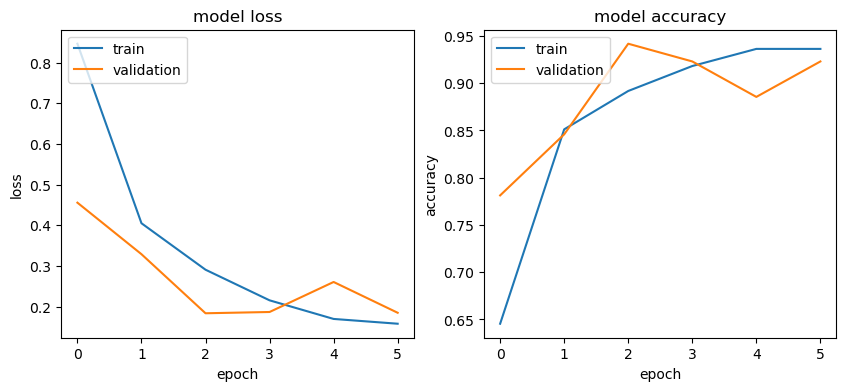

In [55]:
fig, axs = plt.subplots(1,2, figsize=(10,4))

axs[0].plot(model3_history.history['loss'])
axs[0].plot(model3_history.history['val_loss'])
axs[0].set_title('model loss')
axs[0].set_ylabel('loss')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'validation'], loc='upper left')

# summarize history for loss
axs[1].plot(model3_history.history['accuracy'])
axs[1].plot(model3_history.history['val_accuracy'])
axs[1].set_title('model accuracy')
axs[1].set_ylabel('accuracy')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'validation'], loc='upper left');

This will save the model:

In [57]:
#model3.save('models/mobilenet_transfer_learning')

We can again look at the training, validation, and test accuracy of our model.

In [58]:
print(f'This transfer learning base MobileNet model has traning accuracy : {model3.evaluate(traingen,verbose=0)[-1]}\n')
print(f'This transfer learning base MobileNet model has validation accuracy : {model3.evaluate(valgen,verbose=0)[-1]}\n')
print(f'This transfer learning base MobileNet model has testing accuracy : {model3.evaluate(testgen,verbose=0)[-1]}\n')

2023-05-08 03:33:25.567704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


This transfer learning base MobileNet model has traning accuracy : 0.9338778853416443



2023-05-08 03:35:37.491182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


This transfer learning base MobileNet model has validation accuracy : 0.940816342830658



2023-05-08 03:35:41.128583: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


This transfer learning base MobileNet model has testing accuracy : 0.9092159271240234



We can also look at the same precision, recall, and f1-score metrics for each class and compare our transfer learning MobilNet model to the others basic CNN.

/tmp/ipykernel_48/3494886529.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_test_probas = model3.predict_generator(testgen,steps = len(testgen.labels))
2023-05-08 03:35:46.844604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


              precision    recall  f1-score   support

      Glioma       0.88      0.93      0.90       298
  Meningioma       0.86      0.82      0.84       192
   Pituitary       0.99      0.96      0.97       237

    accuracy                           0.91       727
   macro avg       0.91      0.90      0.91       727
weighted avg       0.91      0.91      0.91       727



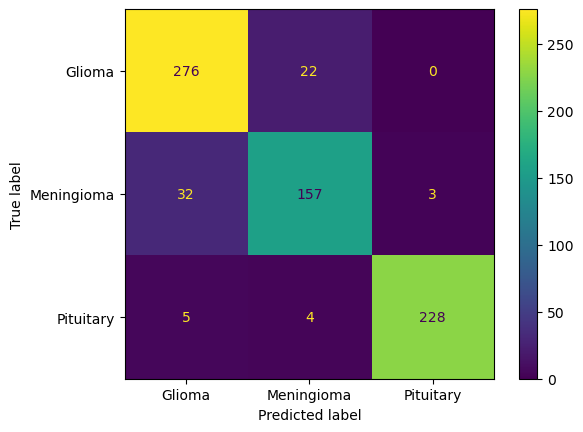

In [59]:
y_test_probas = model3.predict_generator(testgen,steps = len(testgen.labels))
y_test_preds = y_test_probas.argmax(1)
y_test = testgen.labels

print(classification_report(y_test, y_test_preds, target_names = ['Glioma', 'Meningioma', 'Pituitary']))

cm = ConfusionMatrixDisplay.from_predictions(y_test,
                                            y_test_preds,
                                            display_labels = ['Glioma', 'Meningioma', 'Pituitary'])


The results from our transfer learning CNN model using MobileNet as a base with data augmentation and balanced classes are also very promising.  We again see an improvement in the overall test accuracy of the model when compared to our basic CNN models as the acuracy here is 0.91.  While the RESNET base CNN model has a slightly higher accuracy at 0.92, the MobileNet model only has 3.8 million parameters, in comparison to RESNET's over 25 million.  This means that we are able to achieve almost identical results with a much less complex model.  The f1-scores across each class are also similar to the RESNET model, indicating that this smaller, easier to train model, is an improvement over the last.

# 209 Extension: Convolutional XGBoost with Data Augmentation and Balanced Classes

For our 209 Extension to this project we decided to apply Convolution XGBoost (ConvXGB), a deep learning model for classification problems based on CNN and XGBoost, to our problem of tumor classification.  We were inspired by this paper in the literature: "ConvXGB: A new deep learning model for classification problems based on CNN and XGBoost" [https://www.sciencedirect.com/science/article/pii/S1738573319308587], which introsduces ConvXGB and explains how it can apply to image data.  In short, the ConvXGB architecture consists of several stacked convolutional layers and with XGBoost as the last layer of the model. It differs from the previous CNN models we've been using because  because rather than having a Fully Connected (FC) layer, we use an XGBoost model (gradient boosting) to perform the final classification. This introduces simplicity and reduces the number of calculation parameters in the model. In the paper, the authors showed that ConvXGBoost can sometimes achieve higher accuracy than the two individual models (CNNs and XGBoost) do on their own; we would like to explore this ability.  Because we saw overfitting occuring when we used large pre-trained models like RESNET as a base, we are hoping that reducing the number of parameters and simplifying the model may reduce this.  Because we use the CNN for feature extraction and then XGBoost for classification, rather than using a final dense layer which adds lots of parameters, we hope that this will simplfiy the architecture but also improve accuracy through the use of 2 different models.  Another paper "Convolutional XGBoost Model for Brain Tumor Detection" [https://arxiv.org/abs/2301.02317] also applies this type of model to a similar problem and notes that it has a "lower model complexity compared to purely CNNs, making it easier to train and less prone to overfitting." For interested readers, there are also several blog posts about the powers of ConvXGB:
https://jonaac.github.io/works/deepxgboost.html, https://www.kaggle.com/getting-started/147942, etc.

First, we define our base CNN. Here, we'll let the base CNN be the CNN that we trained with RESNET as a base and balanced datasets with data augmentation earlier in the notebook.

In [185]:
ConvXGB_base_model = keras.models.load_model('models/resnet_transfer_learning')

Note: Although here we use our transfer learning RESNET CNN from earlier (because it is already trained on the dataset), in practice, any CNN could be used here as the base model.  You then extract the intermediate layers from this base model and pass them through an XGBoost classifer (rather than a dense layer) in the same manner as is shown below.

Now we creating a intermediate layer model to extract the data from an intermediate dense layer of the model

In [186]:
layer_name='dense_2'
intermediate_layer_model = Model(inputs=ConvXGB_base_model.input,
                                 outputs=ConvXGB_base_model.get_layer(layer_name).output)

intermediate_layer_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

Now we can extract the intermediate output from the CNN base model by predicting on each sample in the train, validation, and test sets.  Here we define generators with a batch size equal to one, so that when we do our predictions to extract the intermediate dense layers, we only predict on each point once.

In [187]:
datagen = ImageDataGenerator()
datagen_aug = ImageDataGenerator(
    rotation_range=5,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest')

tgb = datagen_aug.flow_from_directory(
                                DATA_DIR+'/train_balanced', 
                                target_size=target_size,
                                shuffle = False,
                                batch_size=1,
                                class_mode='categorical', 
                                 color_mode='rgb')

vg = datagen.flow_from_directory(
                                DATA_DIR+'/validation',
                                target_size=target_size,
                                shuffle = False,
                                batch_size=1,
                                class_mode='categorical',
                                color_mode='rgb')

# Test data should not be augmented
testgen = datagen.flow_from_directory(
    DATA_DIR+'/test',  
    target_size=target_size, 
    batch_size=1,
    shuffle = False,
    class_mode='categorical',
    color_mode='rgb') 


intermediate_output_train =intermediate_layer_model.predict_generator(tgb, steps = len(tgb.labels)) 
intermediate_output_train = pd.DataFrame(data=intermediate_output_train)

intermediate_output_val = intermediate_layer_model.predict_generator(vg, steps = len(vg.labels)) 
intermediate_output_val = pd.DataFrame(data=intermediate_output_val)

intermediate_output_test = intermediate_layer_model.predict_generator(testgen, steps = len(testgen.labels)) 
intermediate_output_test = pd.DataFrame(data=intermediate_output_test)

Found 2571 images belonging to 3 classes.
Found 490 images belonging to 3 classes.
Found 727 images belonging to 3 classes.


/tmp/ipykernel_48/1336666075.py:34: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  intermediate_output_train =intermediate_layer_model.predict_generator(tgb, steps = len(tgb.labels))
2023-05-08 06:21:22.245366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
/tmp/ipykernel_48/1336666075.py:37: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  intermediate_output_val = intermediate_layer_model.predict_generator(vg, steps = len(vg.labels))
2023-05-08 06:23:32.432850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG I

Now we take these intermediate outputs from the dense layer of the CNN and use them as inputs along with their corresponding labels to fit an XG Boost classifer.  The idea is that the CNN has extracted feature information from the data.  Now we will use the XGBoost as a classifer rather than using a dense layer (which adds more parameters) like in a CNN.

In [188]:
xgbmodel = XGBClassifier(objective='multi:softprob', 
                      num_class= n_classes)

xgbmodel.fit(intermediate_output_train, tgb.labels)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_class=3,
              num_parallel_tree=None, objective='multi:softprob', ...)

If users desire, they can get a flowchart of the CNN part of the model and the tree part of the model using these two lines of code.

In [ ]:
tf.keras.utils.plot_model(intermediate_layer_model, to_file="intermediate_layer_model.png")
xgb.plot_tree(xgbmodel)

Now we can ook at the training, validation, and test accuracy of the ConvXGB model.

In [189]:
print(f'This ConvXGB model has traning accuracy : {xgbmodel.score(intermediate_output_train, tgb.labels)}\n')
print(f'This ConvXGB model has validation accuracy : {xgbmodel.score(intermediate_output_val, vg.labels)}\n')
print(f'This ConvXGB model has testing accuracy : {xgbmodel.score(intermediate_output_test, testgen.labels)}\n')

This ConvXGB model has traning accuracy : 1.0

This ConvXGB model has validation accuracy : 0.8959183673469387

This ConvXGB model has testing accuracy : 0.90646492434663



We can also look at the same precision, recall, and f1-score metrics for each class and compare our transfer learning ConvXGB model to the others.

              precision    recall  f1-score   support

      Glioma       0.90      0.80      0.84       298
  Meningioma       0.72      0.86      0.78       192
   Pituitary       0.99      0.97      0.98       237

    accuracy                           0.87       727
   macro avg       0.87      0.88      0.87       727
weighted avg       0.88      0.87      0.87       727



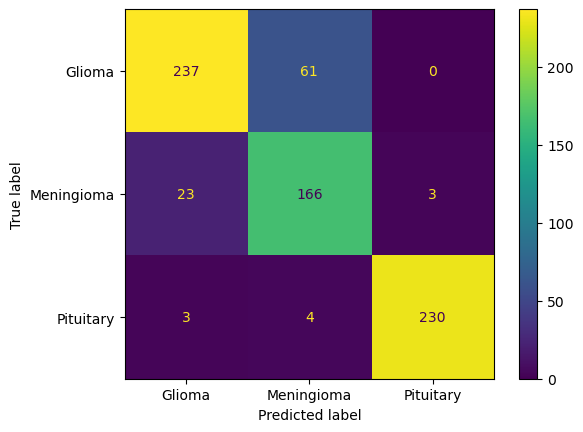

In [183]:
y_test_preds = xgbmodel.predict(intermediate_output_test)
y_test = testgen.labels

print(classification_report(y_test, y_test_preds, target_names = ['Glioma', 'Meningioma', 'Pituitary']))

cm = ConfusionMatrixDisplay.from_predictions(y_test,
                                            y_test_preds,
                                            display_labels = ['Glioma', 'Meningioma', 'Pituitary'])


# Conclusions

### Final Model Result Comparisons

We now have the following results:

```
                                                                                    test accuracy
                                    
baseline logistic regression                                                              0.72  

basic CNN                                                                                 0.81

basic CNN + balanced data + data augmentation                                             0.85

transfer learning base RESNET CNN + balanced data + data augmentation                     0.92

transfer learning base MobileNet CNN + balanced data + data augmentation                  0.91

209 Extension Convolution XGBoost + balanced data + data augmentation                     0.91




```

    
```
Baseline Logistic Regression

                      precision    recall  f1-score  

          Meningioma       0.59      0.33      0.42       
              Glioma       0.65      0.86      0.74       
           Pituitary       0.90      0.86      0.88       


Basic CNN   

                        precision    recall  f1-score   

          Meningioma       0.74      0.58      0.65       
              Glioma       0.78      0.81      0.79       
           Pituitary       0.89      1.00      0.94       
           

Basic CNN + balanced data (BD) + data augmentation (DA) 


                      precision    recall  f1-score  

          Meningioma       0.78      0.74      0.76
              Glioma       0.83      0.86      0.85       
           Pituitary       0.93      0.93      0.93       




transfer learning base RESNET CNN + balanced data (BD) + data augmentation (DA)

                      precision    recall  f1-score   

          Meningioma       0.85      0.86      0.86     
              Glioma       0.93      0.91      0.92      
           Pituitary       0.96      0.98      0.97       
           
           
           
transfer learning base MobileNet CNN + balanced data + data augmentation

                      precision    recall  f1-score  

          Meningioma       0.86      0.82      0.84
              Glioma       0.88      0.93      0.90      
           Pituitary       0.99      0.96      0.97      



209 Extension Convolution XGBoost + balanced data + data augmentation

                      precision    recall  f1-score  

          Meningioma       0.72      0.86      0.78      
              Glioma       0.90      0.80      0.84      
           Pituitary       0.99      0.97      0.98    

           
```

Sometimes tables like this can be overwhelming to interpret.  For this reason, we focus on two main results, the accuracy of each model and the f1-score (a combination of the precision and recall into a single metric by taking their harmonic mean). We then visualize these results for each of the models we built.

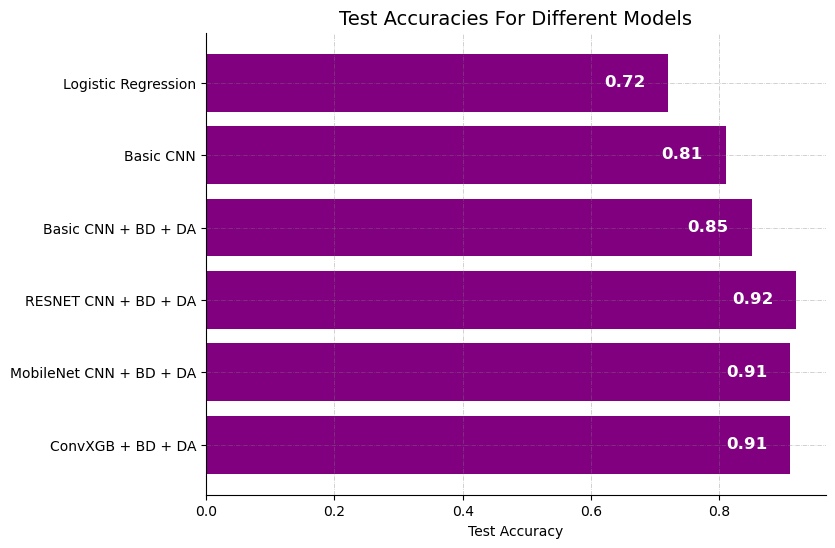

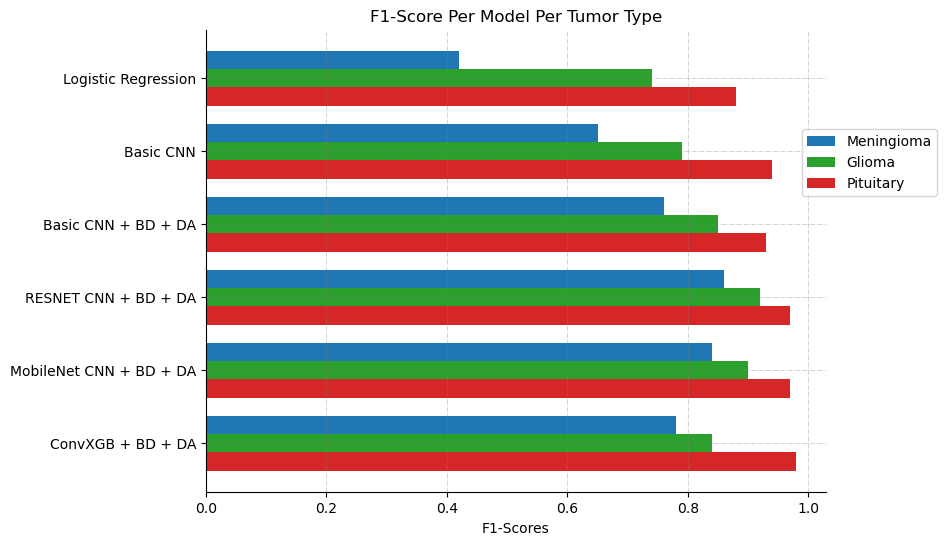

In [197]:
#Plotting the test accuracies in a bar graph
model_names = ['Logistic Regression', 'Basic CNN', 'Basic CNN + BD + DA',  'RESNET CNN + BD + DA', 'MobileNet CNN + BD + DA', 'ConvXGB + BD + DA']
test_accs = [0.72, 0.81, 0.85, 0.92, 0.91, 0.91]

fig, ax = plt.subplots(figsize =(8, 6))
 
# Horizontal Bar Plot
ax.barh(model_names, test_accs, color = 'purple')
y_pos = np.arange(len(model_names))

# Remove axes splines
for s in ['top', 'right']:
    ax.spines[s].set_visible(False)
 

ax.set_yticks(y_pos, labels=model_names)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Test Accuracy')
ax.set_title('Test Accuracies For Different Models', fontsize = 14)

# Add x, y gridlines
ax.grid(visible= True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.5)
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()-0.10, i.get_y()+0.45,
             str((i.get_width())),
             fontsize = 12, fontweight ='bold',
             color ='white')

plt.show()

print()
print()


#Plotting the f1-scores in a bar graph

fig, ax = plt.subplots(figsize =(8, 6))

width = 0.25
  
    
colors = ['tab:blue', 'tab:green', 'tab:red']

mvals = [0.42, 0.65, 0.76, 0.86, 0.84, 0.78]
bar1 = ax.barh(y_pos, mvals, width, color = colors[0])
  
gvals = [0.74, 0.79, 0.85, 0.92, 0.90, 0.84]
bar2 = ax.barh(y_pos+width, gvals, width, color=colors[1])
  
pvals = [0.88, 0.94, 0.93, 0.97, 0.97, 0.98]
bar3 = ax.barh(y_pos+width*2, pvals, width, color = colors[2])

# Remove axes splines
for s in ['top', 'right']:
    ax.spines[s].set_visible(False)
    
# Add x, y gridlines
ax.grid(visible= True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.5)

ax.invert_yaxis()
plt.xlabel('F1-Scores')
plt.title("F1-Score Per Model Per Tumor Type")
  
plt.yticks(y_pos+width, model_names)
plt.legend( (bar1, bar2, bar3), ('Meningioma', 'Glioma', 'Pituitary'), bbox_to_anchor=(0.95, 0.8))
plt.show()
